# Read data and base stats

In [133]:
name_map =  {
    '100_bins': '100Bins',
    '10_bins': '10Bins',
    '5_bins': '5Bins',
    '100_lof_bins': '100LOFBins',
    '10_lof_bins': '10LOFBins',
    '5_lof_bins': '5LOFBins',
    '100_overlapping': "100Overlap",
    '10_overlapping': "10Overlap",
    '10_overlapping': "10Overlap",
    '10_pct_bins': "10%Bins",
    '1_pct_bins': "1%Bins",
    '5_pct_bins': "5%Bins",
    '5_10_100_hierarchy': 'multHRCHY',
    '5lvl_binary_hierarchy': 'binHRCHY',
    'ExAll':'ExAll',
    'ExDates':'ExDat',
    'ExImages':'ExImg',
    'ExNumbers':'ExNum',
    'ExText':"ExTxt",
    'InAll':'InAll', 
    'InDates':'InDat', 
    'InImages':'InImg', 
    'InNumbers':'InNum',
    'InText':'InTxt',
    'LDA_topics':'LDATopics',
    'MKGA':'MKGA',
    'OneEntPerRel':'OneEnt',
    'VGG_classes':'VGGClasses',
    'date_binning':'DatBins',
    'date_features':'DatFeat',
    'propConst':'pConst',
    'propConst_LOF':'pLOFConst',
    'propValConst':'pvConst',
    'propValConst_LOF':'pvLOFConst'
}

In [134]:
import os
import numpy as np
import re
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar 
import torch

%cd ../src

#df = pd. 
h1cases = {}
lof_100 = {}

print('pykeen file does not exist. Writing pykeen file...')
df = pd.DataFrame(columns=["full_name","f1_macro","f1_micro"])
dat = {}   
dfs = []
i = 0
for entry in os.listdir('../data/predicted/'):
    results = np.loadtxt(f'../data/predicted/{entry}', dtype=np.int32, delimiter=',')
    i+=1
    re.sub(r'\$[0-9]+\.csv','',entry)

    dat[re.sub(r'\$[0-9]+\.csv','',entry)] = results
    y_pred = np.array(results[0])
    y_true = np.array(results[1])
    dfs.append(pd.DataFrame(
        [[
            entry,
            f1_score(y_true,y_pred,average='micro'),
            f1_score(y_true,y_pred,average='macro'),
            accuracy_score(y_true,y_pred),
            # precision_score(y_true,y_pred,average='macro'),
            # recall_score(y_true,y_pred,average='macro'),
        ]],
        # columns=["full_name","f1_micro","f1_macro","acc","p","r"]
        columns=["full_name","f1_micro","f1_macro","acc"]
    ))

df = pd.concat(dfs,ignore_index=True)
df['base_name']= df['full_name'].str.extract(r'(.*)\$[0-9]+\.csv')
df['count'] = df.groupby('base_name')["base_name"].transform("count")
df = df.groupby('base_name').mean().round(3)
df = df.reset_index()
df['dataset']= df['base_name'].str.extract(r'(.*?)\+.*')
df['eval_method']= df['base_name'].str.extract(r'.*\$([A-Z]+)')
df['augment'] = df['base_name'].str.extract(r'\+(.*?)\$.*')
df['augment'] = df['augment'].apply(lambda x: name_map[x])
#df['augment'] = [', '.join(map(str, l)) for l in df['steps']]
df['embedder'] = df['base_name'].str.extract(r'\$(.*?)\$')

results = {}
for k, test_pred in df.iterrows():
    res = {}
    base_pred = df[(df['dataset'] == test_pred['dataset']) & (df['eval_method'] == test_pred['eval_method']) & (
        df['embedder'] == test_pred['embedder']) & (df['augment'] == "ExAll")]
    base_pred_name = base_pred['base_name'].values[0]
    true_y = dat[base_pred_name][1] #true values
    base_pred_y = dat[base_pred_name][0] #base predictor ( ex all)
    test_pred_y = dat[test_pred['base_name']][0] #Test predictor
    base_table = base_pred_y == true_y
    test_table = test_pred_y == true_y
    # print(test_pred['base_name'])
    if test_pred['base_name'] == "dmg777k+InAll$TransE$KNN":
        h1cases['true_y'] = true_y
        h1cases['base_pred_y'] = base_pred_y
        h1cases['test_pred_y'] = test_pred_y
        h1cases['base_table'] = base_table
        h1cases['test_table'] = test_table
    if test_pred['base_name'] == "amplus+propConst_LOF$TransE$KNN":
        print("here")
        lof_100['true_y'] = true_y
        lof_100['base_pred_y'] = base_pred_y
        lof_100['test_pred_y'] = test_pred_y
        lof_100['base_table'] = base_table
        lof_100['test_table'] = test_table
        
    #       t   f   
    #   t   a   b   <- test true
    #   f   c   d
    res["a"] = (test_table&base_table).sum()
    res["b"] = (test_table&~base_table).sum()
    res["c"] = (~test_table&base_table).sum()
    res["d"] = (~test_table&~base_table).sum()
    res["base_pred_acc"] = base_pred.acc.values[0]
    mcn = mcnemar([[res["a"], res["b"]], [res["c"], res["d"]]], exact=False,correction=True)
    res["statistic"] = mcn.__dict__['statistic']
    res["pvalue"] = mcn.__dict__['pvalue']
    results[test_pred['base_name']] = res

df["a"] = df['base_name'].apply(lambda name : results[name]["a"])
df["b"] = df['base_name'].apply(lambda name : results[name]["b"])
df["c"] = df['base_name'].apply(lambda name : results[name]["c"])
df["d"] = df['base_name'].apply(lambda name : results[name]["d"])

df["base_pred_acc"] = df['base_name'].apply(lambda name : results[name]["base_pred_acc"])
df["statistic"] = df['base_name'].apply(lambda name : results[name]["statistic"])
df["pvalue"] = df['base_name'].apply(lambda name : results[name]["pvalue"])

df["acc_delta"] = df['acc']-df['base_pred_acc']
df["pct_acc_delta"] = df["acc_delta"]/df['base_pred_acc']*100
df["p_test_passed"] = df["pvalue"] < 0.05
df = df.drop(columns='base_name')


e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src
pykeen file does not exist. Writing pykeen file...


C:\Users\Noctris\AppData\Local\Temp\ipykernel_25948\670446127.py:44: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('base_name').mean().round(3)
c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\statsmodels\stats\contingency_tables.py:1348: RuntimeWarning: divide by zero encountered in scalar divide
  statistic = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


here


In [ ]:
df

In [135]:
df['augment'].unique()

array(['100Bins', '100LOFBins', '100Overlap', '10Bins', '10LOFBins',
       '10Overlap', '10%Bins', '1%Bins', 'multHRCHY', '5Bins', '5LOFBins',
       '5%Bins', 'binHRCHY', 'ExAll', 'ExDat', 'ExImg', 'ExNum', 'ExTxt',
       'InAll', 'InDat', 'InImg', 'InNum', 'InTxt', 'LDATopics', 'MKGA',
       'OneEnt', 'VGGClasses', 'DatBins', 'DatFeat', 'pConst',
       'pLOFConst', 'pvConst', 'pvLOFConst'], dtype=object)

In [136]:
results['amplus+100_lof_bins$TransE$KNN']

{'a': 12335,
 'b': 1759,
 'c': 1301,
 'd': 4605,
 'base_pred_acc': 0.682,
 'statistic': 68.25130718954249,
 'pvalue': 1.4393159934572077e-16}

In [274]:
df.dtypes

f1_micro         float64
f1_macro         float64
acc              float64
count            float64
dataset           object
eval_method       object
augment           object
embedder          object
a                  int32
b                  int32
c                  int32
d                  int32
base_pred_acc    float64
statistic        float64
pvalue           float64
acc_delta        float64
p_test_passed       bool
dtype: object

In [137]:
def results_as_latex(df, name="baselines", path="../docs/tables/", 
                      values='acc', index=['embedder', 'augment'], 
                      columns=['dataset', 'eval_method'], 
                      aug_approaches=["ExAll", "InAll", "OneEntPerRel"],
                      aggfunc='mean'):
    pt = df.pivot_table(
        values=values,
        index=index,
        columns=columns,
        aggfunc=aggfunc).query("augment ==  @aug_approaches")
    s = pt.style.format(precision=3)
    s = s.highlight_max(axis=0, props='textbf:--rwrap;')
    if len(index) >1 and type(index)!=str:
        s = s.format_index("\\rotatebox[origin=c]{{90}}{{{}}}", axis=0,level=0, escape="latex")

    s = s.to_latex(multirow_align="c", 
        hrules=True, 
        clines="skip-last;index",
        caption=(f"Accuracy Results for {name} Approaches"),
        label=f"tab:{name}",
        position="h",
        position_float="centering",
        multicol_align="c"
        
        )#
    s = s.replace(r'& eval_method',"\\cmidrule(lr){3-4}\\cmidrule(lr){5-6}\\cmidrule(lr){7-8}\\cmidrule(lr){9-10}\n &" )
    s = s.replace("[[","[\[" )
    s = s.replace("]]","\]]" )
    s = s.replace("_"," " )
    s = s.replace('dataset',"")
    s = re.sub(r'embedder & augment.*', '', s)
    s = s.replace('\\cline{1-2}\n\\bottomrule',"\\bottomrule")
    # s = s.replace('[h]',"[h]\n\\footnotesize")
    s = s.replace('\n\n','\n')


    with open(f'{path}{name}.tex', "w") as f:
        f.write(s)


In [2]:
def get_pivot_of_df(df, values='acc', 
                    index=['embedder','augment'], 
                    columns=['dataset', 'eval_method'], 
                    aug_approaches = ["ExAll", "InAll", "OneEntPerRel"], 
                    aggfunc='mean'):
    return df.pivot_table(
            values=values,
            index=index,
            columns=columns,
            aggfunc=aggfunc).query("augment ==  @aug_approaches")

In [128]:
df

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,pct_acc_delta,p_test_passed
0,0.458,0.240,0.458,1.0,amplus,KNN,100_bins,DistMult,6432,2720,2722,8126,0.458,0.000184,9.891845e-01,0.000,0.000000,False
1,0.492,0.315,0.492,1.0,amplus,SVM,100_bins,DistMult,7335,2503,2898,7264,0.512,28.742085,8.268718e-08,-0.020,-3.906250,True
2,0.498,0.273,0.498,1.0,amplus,KNN,100_bins,RDF2Vec,8935,1016,2074,7975,0.550,361.569256,1.281991e-80,-0.052,-9.454545,True
3,0.501,0.229,0.501,1.0,amplus,SVM,100_bins,RDF2Vec,9316,698,1412,8574,0.536,240.933175,2.461689e-54,-0.035,-6.529851,True
4,0.678,0.478,0.678,1.0,amplus,KNN,100_bins,TransE,12236,1330,1400,5034,0.682,1.743956,1.866383e-01,-0.004,-0.586510,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0.620,0.151,0.620,1.0,mdgenre,SVM,propValConst_LOF,DistMult,1751,110,114,1025,0.622,0.040179,8.411318e-01,-0.002,-0.321543,False
720,0.588,0.196,0.588,1.0,mdgenre,KNN,propValConst_LOF,RDF2Vec,1635,129,135,1101,0.590,0.094697,7.582888e-01,-0.002,-0.338983,False
721,0.661,0.206,0.661,1.0,mdgenre,SVM,propValConst_LOF,RDF2Vec,1945,37,41,977,0.662,0.115385,7.340952e-01,-0.001,-0.151057,False
722,0.643,0.203,0.643,1.0,mdgenre,KNN,propValConst_LOF,TransE,1818,112,84,986,0.634,3.719388,5.378409e-02,0.009,1.419558,False


In [95]:
df['augment'].unique()

array(['100_bins', '100_lof_bins', '100_overlapping', '10_bins',
       '10_lof_bins', '10_overlapping', '10_pct_bins', '1_pct_bins',
       '5_10_100_hierarchy', '5_bins', '5_lof_bins', '5_pct_bins',
       '5lvl_binary_hierarchy', 'ExAll', 'ExDates', 'ExImages',
       'ExNumbers', 'ExText', 'InAll', 'InDates', 'InImages', 'InNumbers',
       'InText', 'LDA_topics', 'OneEntPerRel', 'VGG_classes',
       'date_binning', 'date_features', 'propConst', 'propConst_LOF',
       'propValConst', 'propValConst_LOF', 'testbins'], dtype=object)

In [125]:
import seaborn as sns
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib
import re
def set_label(score):
    if score <= 0.0001:
        return '****'
    elif score <= 0.001:
        return '***'
    elif score <= 0.01:
        return '**'
    elif score <= 0.05:
        return '*'
    # elif score >= 0.9999:
    #     return '(****)'
    # elif score >= 0.999:
    #     return '(***)'
    # elif score >= 0.99:
    #     return '(**)'
    # elif score >= 0.95:
    #     return '(*)'
    else:
        return " "
        # return "$^{{ns}}$"


def extended_wilcoxon(df):
    approaches = ['ExAll','100_bins', '100_lof_bins', '100_overlapping', '10_bins',
       '10_lof_bins', '10_overlapping', '10_pct_bins', '1_pct_bins',
       '5_10_100_hierarchy', '5_bins', '5_lof_bins', '5_pct_bins',
       '5lvl_binary_hierarchy', 'ExDates', 'ExImages',
       'ExNumbers', 'ExText', 'InAll', 'InDates', 'InImages', 'InNumbers',
       'InText', 'LDA_topics', 'OneEntPerRel', 'VGG_classes',
       'date_binning', 'date_features', 'propConst', 'propConst_LOF',
       'propValConst', 'propValConst_LOF','MKGA']
    pt_acc = df.pivot_table(values="acc", columns=['augment'], index=[
                            'dataset', 'embedder', 'eval_method']).reset_index()
    pt_dates_acc = df[df['dataset'].isin(['amplus', 'mdgenre'])].pivot_table(
        values="acc", columns=['augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    pt_f1 = df.pivot_table(values="f1_macro", columns=['augment'], index=[
                            'dataset', 'embedder', 'eval_method']).reset_index()
    pt_dates_f1 = df[df['dataset'].isin(['amplus', 'mdgenre'])].pivot_table(
        values="f1_macro", columns=['augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    wilcoxon_results = {}
    for i in range(len(approaches)):
        acc_score = list(pt_acc[approaches[i]].values)
        f1_score = list(pt_f1[approaches[i]].values)
        mn_true = df[df['augment']==approaches[i]]["p_test_passed"].sum()
        mn_all =  df[df['augment']==approaches[i]]["p_test_passed"].count()
        if i == 0:
            pass
        else:
            
            if re.search(r'[dD]ate', approaches[i]):
                acc_score = list(pt_dates_acc[approaches[i]].values)
                f1_score = list(pt_dates_f1[approaches[i]].values)
                mn_true = df[(df['dataset'].isin(['amplus', 'mdgenre']))&(df['augment']==approaches[i])]["p_test_passed"].sum()
                mn_all =  df[(df['dataset'].isin(['amplus', 'mdgenre']))&(df['augment']==approaches[i])]["p_test_passed"].count()
                # score = list(pt_dates[approaches[i]].values)
                statistic_acc, p_value_acc = wilcoxon(
                     acc_score, list(pt_dates_acc['ExAll'].values), alternative="greater")
                statistic_f1, p_value_f1 = wilcoxon(
                     f1_score, list(pt_dates_acc['ExAll'].values), alternative="greater")
            else:
                statistic_acc, p_value_acc = wilcoxon(
                     acc_score, list(pt_acc['ExAll'].values), alternative="greater")
                statistic_f1, p_value_f1 = wilcoxon(
                     f1_score, list(pt_f1['ExAll'].values), alternative="greater")
            # print(f'result: {approaches[i]} - {statistic} - {p_value}')
            acc_label =set_label(p_value_acc)
            f1_label =set_label(p_value_f1)

            wilcoxon_results[approaches[i]] ={}
            wilcoxon_results[approaches[i]]['p_value_acc'] =p_value_acc
            wilcoxon_results[approaches[i]]['acc_label'] =acc_label
            wilcoxon_results[approaches[i]]['p_value_f1'] =p_value_f1
            wilcoxon_results[approaches[i]]['f1_label'] =f1_label
            wilcoxon_results[approaches[i]]['#_passed'] =mn_true
            wilcoxon_results[approaches[i]]['%_passed'] =mn_true/mn_all

            print(f'result: {approaches[i]} - {p_value_acc} - {acc_label} - {p_value_f1} - {f1_label}')
    return wilcoxon_results







def wilcoxon_test(df, approaches, measure='acc', zero_method="pratt", correction=True, alternative="greater"):
    pt = df[df['augment'].isin(approaches)].pivot_table(values=measure, columns=[
        'augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    pt_dates = df[(df['augment'].isin(approaches)) & (df['dataset'].isin(['amplus', 'mdgenre']))].pivot_table(
        values=measure, columns=['augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    scores = []
    wilcoxon_results = {}


    for i in range(len(approaches)):
        score = list(pt[approaches[i]].values)

    # print(score)
        scores.append(score)
        label = approaches[i]
        label = label.replace("_", " ")

        if i == 0:
            pass
        else:
            statistic, p_value = wilcoxon(
                scores[0], score, zero_method=zero_method, correction=correction, alternative=alternative)
            # if re.search(r'[dD]ate', approaches[i]):
            #     score = list(pt_dates[approaches[i]].values)
            #     statistic, p_value = wilcoxon(list(pt_dates['ExAll'].values), score)
            
            print(f'result: {label} - {statistic} - {p_value}')


def plot_violin(df, approaches, name, path="../docs/plots/", measure='acc'):
    pt = df[df['augment'].isin(approaches)].pivot_table(values=measure, columns=[
        'augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    pt_dates = df[(df['augment'].isin(approaches)) & (df['dataset'].isin(['amplus', 'mdgenre']))].pivot_table(
        values=measure, columns=['augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    scores = []
    wilcoxon_results = {}
    labels = []
    for i in range(len(approaches)):
        score = list(pt[approaches[i]].values)
    # print(score)
        scores.append(score)
        label = approaches[i]
        label = label.replace("_", " ")

        if i == 0:
            labels.append(label)
        else:
            if re.search(r'[dD]ate', approaches[i]):
                score = list(pt_dates[approaches[i]].values)
                statistic, p_value = wilcoxon(
                    list(score, pt_dates['ExAll'].values))
            else:
                statistic, p_value = wilcoxon(score,scores[0],correction=True, alternative='greater')
            # print(f'result: {approaches[i]} - {statistic} - {p_value}')
            wilcoxon_results[approaches[i]] = p_value
            if p_value <= 0.0001:
                labels.append(f'{label}****')
            elif p_value <= 0.001:
                labels.append(f'{label}***')
            elif p_value <= 0.01:
                labels.append(f'{label}**')
            elif p_value <= 0.05:
                labels.append(f'{label}*')
            else:
                labels.append(f'{label}$^{{ns}}$')
            print(f'result: {labels[-1]} - {statistic} - {p_value}')

    # print(wilcoxon_results)
    sns.set_theme(context="paper", style="whitegrid",font_scale=1,palette='colorblind')
    plt.clf()
    plt.figure(figsize=(7.5, 4))
    # plt.figure(dpi=100)
    sns.violinplot(data=scores)
    sns.boxplot( data=scores, width=0.2, color="black")
    plt.xticks(ticks=np.linspace(0, len(approaches) - 1,
               len(approaches), dtype=np.int32), labels=labels)

    plt.ylabel('Accuracy')

    plt.savefig(f'{path}{name}.pgf', format='pgf', backend='pgf')
    return wilcoxon_results


In [5]:
def plot_vi(df, approaches, name, path="../docs/plots/", measure='acc'):
    pt = df[df['augment'].isin(approaches)].pivot_table(values=measure, columns=[
        'augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    pt_dates = df[(df['augment'].isin(approaches)) & (df['dataset'].isin(['amplus', 'mdgenre']))].pivot_table(
        values=measure, columns=['augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    scores = []
    wilcoxon_results = {}
    labels = []
    for i in range(len(approaches)):
        score = list(pt[approaches[i]].values)
    # print(score)
        scores.append(score)
        label = approaches[i]
        label = label.replace("_", " ")

        if i == 0:
            labels.append(label)
        else:
            if re.search(r'[dD]ate', approaches[i]):
                score = list(pt_dates[approaches[i]].values)
                statistic, p_value = wilcoxon(
                    list(pt_dates['ExAll'].values), score)
            else:
                statistic, p_value = wilcoxon(scores[0], score)
            # print(f'result: {approaches[i]} - {statistic} - {p_value}')
            wilcoxon_results[approaches[i]] = p_value
            if p_value <= 0.0001:
                labels.append(f'{label}****')
            elif p_value <= 0.001:
                labels.append(f'{label}***')
            elif p_value <= 0.01:
                labels.append(f'{label}**')
            elif p_value <= 0.05:
                labels.append(f'{label}*')
            else:
                labels.append(f'{label}$^{{ns}}$')
            print(f'result: {labels[-1]} - {statistic} - {p_value}')

    # print(wilcoxon_results)

    # plt.clf()
    # plt.figure(figsize=(7.5, 4))
    # # plt.figure(dpi=100)
    # sns.violinplot(data=scores)
    # plt.xticks(ticks=np.linspace(0, len(approaches) - 1,
    #            len(approaches), dtype=np.int32), labels=labels)

    # plt.ylabel('Accuracy')

    # plt.savefig(f'{path}{name}.pgf', format='pgf', backend='pgf')
    return scores,labels,approaches

In [6]:
res = extended_wilcoxon(df)
tbl = pd.DataFrame(res).T

s = tbl.style.format(precision=5)
s = s.highlight_min(axis=0, props='textbf:--rwrap;',subset=['p_value_acc','p_value_f1'])
s = s.highlight_max(axis=0, props='textbf:--rwrap;',subset=['#_passed','%_passed'])


s = s.to_latex(hrules=True, 

    caption=(f"Overall Results for the wilcoxon test",f"see legend"),
    label=f"tab:wilcoxonextensive",
    position="h",
    position_float="centering",
    multicol_align="c"
        
    )#
#s = s.replace(r'& eval_method',"\\cmidrule(lr){3-4}\\cmidrule(lr){5-6}\\cmidrule(lr){7-8}\\cmidrule(lr){9-10}\n &" )
s = s.replace("[[","[\[" )
s = s.replace("]]","\]]" )
s = s.replace("_"," " )
s = s.replace('dataset',"")
s = re.sub(r'embedder & augment.*', '', s)
s = s.replace('\\cline{1-2}\n\\bottomrule',"\\bottomrule")
# s = s.replace('[h]',"[h]\n\\footnotesize")
s = s.replace('\n\n','\n')


with open(f'../docs/tables/wilcoxon_extensive.tex', "w") as f:
    f.write(s)

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


result: 100_bins - 0.9926052760448283 -   - 0.39210170409602285 -  
result: 100_lof_bins - 0.2919030785560608 -   - 0.0024053454399108887 - **
result: 100_overlapping - 0.9787554144859314 -   - 0.4387035369873047 -  
result: 10_bins - 0.9910648465156555 -   - 0.5833132863044739 -  
result: 10_lof_bins - 0.7052212151758461 -   - 0.15144962072372437 -  
result: 10_overlapping - 0.9925546640065018 -   - 0.647621750831604 -  
result: 10_pct_bins - 0.8530534235200677 -   - 0.7888292670249939 -  
result: 1_pct_bins - 0.8854051828384399 -   - 0.9580399990081787 -  
result: 5_10_100_hierarchy - 0.9606353640556335 -   - 0.20305603742599487 -  
result: 5_bins - 0.9654491543769836 -   - 0.8678285479545593 -  
result: 5_lof_bins - 0.954474971757278 -   - 0.36287039518356323 -  
result: 5_pct_bins - 0.6252860986541446 -   - 0.7080969214439392 -  
result: 5lvl_binary_hierarchy - 0.9697864651679993 -   - 0.7177055478096008 -  
result: ExDates - 0.39458294368717556 -   - 1.0 -  
result: ExImages - 0.0

In [7]:
tbl

,p_value_acc,acc_label,p_value_f1,f1_label,#_passed,%_passed
100_bins,0.992605,,0.392102,,10,0.416667
100_lof_bins,0.291903,,0.002405,**,10,0.416667
100_overlapping,0.978755,,0.438704,,11,0.458333
10_bins,0.991065,,0.583313,,10,0.416667
10_lof_bins,0.705221,,0.15145,,8,0.333333
10_overlapping,0.992555,,0.647622,,11,0.458333
10_pct_bins,0.853053,,0.788829,,14,0.583333
1_pct_bins,0.885405,,0.95804,,11,0.458333
5_10_100_hierarchy,0.960635,,0.203056,,16,0.666667
5_bins,0.965449,,0.867829,,11,0.458333


# side calculations

In [561]:
for i in range(len(h1cases['true_y'])):
    if (h1cases['base_table'][i]) & (h1cases['test_table'][i]==False):
        print(f"{i} - {h1cases['true_y'][i]} - {h1cases['base_pred_y'][i]} - {h1cases['test_pred_y'][i]}")

0 - 1 - 1 - 4
2 - 1 - 1 - 4
12 - 4 - 4 - 1
14 - 1 - 1 - 3
18 - 1 - 1 - 3
22 - 1 - 1 - 3
30 - 1 - 1 - 4
61 - 1 - 1 - 0
74 - 1 - 1 - 3
76 - 3 - 3 - 1
83 - 1 - 1 - 3
88 - 1 - 1 - 4
94 - 3 - 3 - 4
100 - 1 - 1 - 4
109 - 1 - 1 - 4
117 - 1 - 1 - 3
124 - 1 - 1 - 3
134 - 1 - 1 - 4
135 - 3 - 3 - 1
139 - 1 - 1 - 3
144 - 1 - 1 - 4
145 - 3 - 3 - 1
158 - 1 - 1 - 4
163 - 3 - 3 - 4
181 - 1 - 1 - 4
187 - 1 - 1 - 4
197 - 1 - 1 - 4
203 - 4 - 4 - 1
207 - 1 - 1 - 4
212 - 4 - 4 - 1
234 - 3 - 3 - 1
243 - 1 - 1 - 3
268 - 1 - 1 - 3
269 - 1 - 1 - 4
273 - 1 - 1 - 0
288 - 1 - 1 - 4
297 - 1 - 1 - 4
322 - 1 - 1 - 4
337 - 3 - 3 - 1
358 - 1 - 1 - 3
361 - 2 - 2 - 1
367 - 1 - 1 - 4
386 - 3 - 3 - 1
397 - 1 - 1 - 4
399 - 3 - 3 - 1
412 - 3 - 3 - 1
419 - 1 - 1 - 4
424 - 1 - 1 - 3
447 - 1 - 1 - 4
452 - 3 - 3 - 1
490 - 3 - 3 - 1
503 - 1 - 1 - 0
516 - 1 - 1 - 3
517 - 1 - 1 - 4
525 - 1 - 1 - 4
534 - 1 - 1 - 4
535 - 1 - 1 - 4
564 - 1 - 1 - 3
580 - 1 - 1 - 4
589 - 1 - 1 - 4
593 - 1 - 1 - 3
601 - 3 - 3 - 1
617 - 1 - 1 - 4
619 - 1

In [562]:
for i in range(len(h1cases['true_y'])):
    if (h1cases['base_table'][i]==False) & (h1cases['test_table'][i]):
        print(f"{i} - {h1cases['true_y'][i]} - {h1cases['base_pred_y'][i]} - {h1cases['test_pred_y'][i]}")

8 - 3 - 1 - 3
9 - 4 - 3 - 4
10 - 3 - 1 - 3
15 - 3 - 1 - 3
16 - 3 - 1 - 3
19 - 3 - 1 - 3
21 - 3 - 4 - 3
26 - 3 - 1 - 3
31 - 3 - 1 - 3
36 - 4 - 1 - 4
38 - 1 - 3 - 1
41 - 2 - 3 - 2
50 - 3 - 1 - 3
62 - 1 - 3 - 1
66 - 3 - 1 - 3
71 - 3 - 1 - 3
72 - 1 - 3 - 1
80 - 3 - 1 - 3
81 - 3 - 1 - 3
85 - 4 - 1 - 4
87 - 3 - 1 - 3
95 - 2 - 4 - 2
99 - 2 - 3 - 2
102 - 3 - 1 - 3
104 - 1 - 3 - 1
106 - 3 - 1 - 3
107 - 3 - 1 - 3
118 - 3 - 1 - 3
119 - 1 - 4 - 1
122 - 3 - 1 - 3
132 - 3 - 1 - 3
152 - 4 - 1 - 4
165 - 4 - 3 - 4
168 - 3 - 1 - 3
170 - 3 - 1 - 3
171 - 3 - 2 - 3
173 - 2 - 1 - 2
178 - 4 - 1 - 4
183 - 3 - 1 - 3
188 - 4 - 1 - 4
201 - 4 - 1 - 4
206 - 1 - 3 - 1
209 - 1 - 3 - 1
217 - 4 - 1 - 4
220 - 4 - 1 - 4
221 - 1 - 3 - 1
223 - 3 - 4 - 3
227 - 1 - 4 - 1
235 - 4 - 2 - 4
237 - 3 - 1 - 3
239 - 0 - 4 - 0
241 - 4 - 1 - 4
244 - 3 - 1 - 3
247 - 3 - 1 - 3
253 - 3 - 1 - 3
263 - 2 - 3 - 2
264 - 3 - 1 - 3
267 - 4 - 3 - 4
270 - 1 - 3 - 1
285 - 1 - 3 - 1
289 - 3 - 1 - 3
294 - 4 - 1 - 4
298 - 3 - 1 - 3
299 - 2 - 1 - 2
3

In [577]:
mc= mcnemar([[6032, 1032], [818, 3369]], exact=False,correction=True)
print(mc)

pvalue      7.339821337428436e-07
statistic   24.523783783783784


In [164]:
results['dmg777k+InAll$TransE$KNN']

{'a': 809,
 'b': 395,
 'c': 203,
 'd': 594,
 'base_pred_acc': 0.506,
 'statistic': 61.00501672240803,
 'pvalue': 5.692955409037683e-15}

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
lof_100
cm =  confusion_matrix(lof_100["true_y"], lof_100["test_pred_y"])

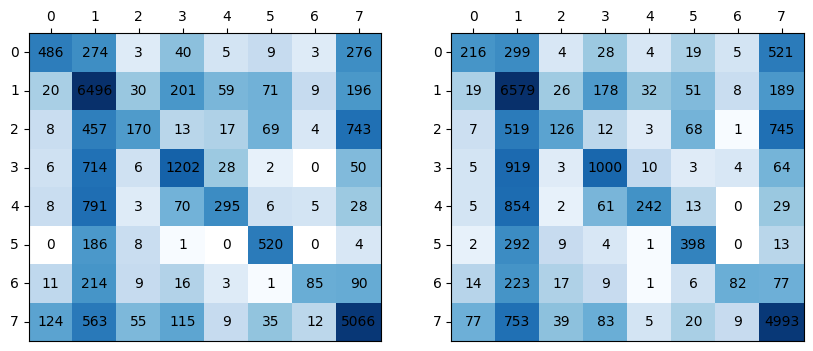

In [86]:
# Create labels for the classes
from matplotlib.colors import LogNorm
cm =  confusion_matrix(lof_100["true_y"], lof_100["test_pred_y"])
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7']

# # plt.figure.fig
fig, ax = plt.subplots(1,2, figsize=(10, 4))


heatmap = ax[0].pcolor(cm[::-1], cmap='Blues', norm=LogNorm(vmin=1, vmax=cm.max()))  # Reverse the matrix to have "true true" at the top left corner

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j + 0.5, i + 0.5, cm[::-1][i, j], ha='center', va='center')

# Set the ticks in the middle of the cells
ax[0].set_xticks(np.arange(cm.shape[1]) + 0.5, minor=False)
ax[0].set_yticks(np.arange(cm.shape[0]) + 0.5, minor=False)

# Add the labels on top
ax[0].set_xticklabels(class_labels, ha='center')  # Align the labels to the left
ax[0].set_yticklabels(class_labels[::-1], va='center')  # Reverse and align the labels to the bottom
# ax.invert_yaxis()
ax[0].xaxis.tick_top()
# ax[0].colorbar(heatmap)

cm =  confusion_matrix(lof_100["true_y"], lof_100["base_pred_y"])
heatmap = ax[1].pcolor(cm[::-1], cmap='Blues', norm=LogNorm(vmin=1, vmax=cm.max()))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[1].text(j + 0.5, i + 0.5, cm[::-1][i, j], ha='center', va='center')

# Set the ticks in the middle of the cells
ax[1].set_xticks(np.arange(cm.shape[1]) + 0.5, minor=False)
ax[1].set_yticks(np.arange(cm.shape[0]) + 0.5, minor=False)

# Add the labels on top
ax[1].set_xticklabels(class_labels, ha='center')  # Align the labels to the left
ax[1].set_yticklabels(class_labels[::-1], va='center')  # Reverse and align the labels to the bottom
# ax.invert_yaxis()
ax[1].xaxis.tick_top()
# ax[1].colorbar(heatmap)


# Add colorbar
# cbar = plt.colorbar(heatmap)

plt.show()

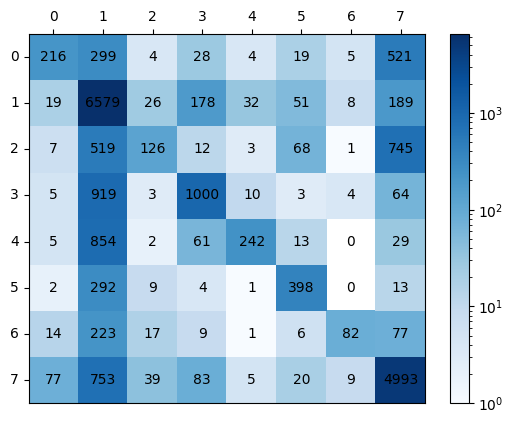

In [39]:
# Create labels for the classes
cm =  confusion_matrix(lof_100["true_y"], lof_100["base_pred_y"])
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7']


fig, ax = plt.subplots()

heatmap = ax.pcolor(cm[::-1], cmap='Blues', norm=LogNorm(vmin=1, vmax=cm.max()))  # Reverse the matrix to have "true true" at the top left corner

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, cm[::-1][i, j], ha='center', va='center')

# Set the ticks in the middle of the cells
ax.set_xticks(np.arange(cm.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(cm.shape[0]) + 0.5, minor=False)

# Add the labels on top
ax.set_xticklabels(class_labels, ha='center')  # Align the labels to the left
ax.set_yticklabels(class_labels[::-1], va='center')  # Reverse and align the labels to the bottom
# ax.invert_yaxis()
ax.xaxis.tick_top()

# Add colorbar
cbar = plt.colorbar(heatmap)

plt.show()

In [19]:
class_labels

['0', '1', '2', '3', '4', '5', '6', '7']

In [8]:
import matplotlib.pyplot as plt
import numpy as np


# Define the 2x2 matrix
best_case = results['dmg777k+100_LOF_bins$TransE$KNN']
matrix = np.array([[best_case['a'],best_case['b']],[best_case['c'],best_case['d']]])

# Define the labels for the rows and columns
row_labels = ['Condition A', 'Condition B']
col_labels = ['Condition A', 'Condition B']

# Create a figure and an axis
fig, ax = plt.subplots()

heatmap = ax.pcolor(matrix[::-1], cmap='Blues')  # Reverse the matrix to have "true true" at the top left corner
# Add colorbar
# cbar = plt.colorbar(heatmap)
# Add labels to each cell
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j + 0.5, i + 0.5, matrix[::-1][i, j], ha='center', va='center')

# Set the ticks in the middle of the cells
ax.set_xticks(np.arange(matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0]) + 0.5, minor=False)

# Add the labels on top
ax.set_xticklabels(col_labels, ha='center')  # Align the labels to the left
ax.set_yticklabels(row_labels[::-1], va='center')  # Reverse and align the labels to the bottom
# ax.invert_yaxis()
ax.xaxis.tick_top()

# Add colorbar
cbar = plt.colorbar(heatmap)



# Show the plot
plt.show()

KeyError: 'dmg777k+100_LOF_bins$TransE$KNN'

# Baseline Tables

## baselines

result: InAll** - 235.0 - 0.006889641284942627
result: OneEnt* - 224.0 - 0.016992568969726562


dataset          amplus        dmg777k        dmgfull        mdgenre       
eval_method         KNN    SVM     KNN    SVM     KNN    SVM     KNN    SVM
embedder augment                                                           
DistMult ExAll    0.458  0.512   0.548  0.542   0.619  0.658   0.605  0.622
         InAll    0.477  0.546   0.593  0.611   0.560  0.576   0.575  0.610
         OneEnt   0.511  0.549   0.517  0.501   0.613  0.649   0.599  0.617
RDF2Vec  ExAll    0.550  0.536   0.586  0.606   0.629  0.661   0.590  0.662
         InAll    0.616  0.616   0.626  0.628   0.635  0.685   0.583  0.658
         OneEnt   0.588  0.612   0.630  0.609   0.631  0.679   0.565  0.657
TransE   ExAll    0.682  0.708   0.506  0.528   0.649  0.662   0.634  0.646
         InAll    0.727  0.761   0.602  0.611   0.665  0.688   0.639  0.649
         OneEnt   0.737  0.761   0.610  0.621   0.657  0.673   0.641  0.647

<Figure size 640x480 with 0 Axes>

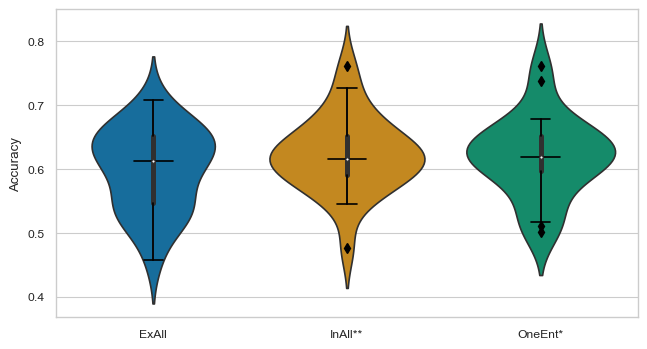

In [140]:
aug_approaches=["ExAll", "InAll", "OneEnt"]
results_as_latex(df, aug_approaches=aug_approaches, name="Literal Type Unaware Baseline")
plot_violin(df,aug_approaches, name="Baseline Results")
# results_as_latex2(df, aug_approaches=aug_approaches, name="baselines")
get_pivot_of_df(df)
get_pivot_of_df(df,aug_approaches=aug_approaches, values='acc')


In [421]:
get_pivot_of_df(df, values="f1_micro")


dataset               amplus        dmg777k        dmgfull        mdgenre  \
eval_method              KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                            
DistMult ExAll         0.458  0.512   0.548  0.542   0.619  0.658   0.605   
         InAll         0.477  0.546   0.593  0.611   0.560  0.576   0.575   
         OneEntPerRel  0.511  0.549   0.517  0.501   0.613  0.649   0.599   
RDF2Vec  ExAll         0.550  0.536   0.586  0.606   0.629  0.661   0.590   
         InAll         0.616  0.616   0.626  0.628   0.635  0.685   0.583   
         OneEntPerRel  0.588  0.612   0.630  0.609   0.631  0.679   0.565   
TransE   ExAll         0.682  0.708   0.506  0.528   0.649  0.662   0.634   
         InAll         0.727  0.761   0.602  0.611   0.665  0.688   0.639   
         OneEntPerRel  0.737  0.761   0.610  0.621   0.657  0.673   0.641   

dataset                       
eval_method              SVM  
embedder augment              
DistMult ExAll         0.622  
         InAll         0.610  
         OneEntPerRel  0.617  
RDF2Vec  ExAll         0.662  
         InAll         0.658  
         OneEntPerRel  0.657  
TransE   ExAll         0.646  
         InAll         0.649  
         OneEntPerRel  0.647

In [364]:
get_pivot_of_df(df, values='acc_delta')

dataset               amplus        dmg777k        dmgfull        mdgenre  \
eval_method              KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                            
DistMult ExAll         0.000  0.000   0.000  0.000   0.000  0.000   0.000   
         InAll         0.019  0.034   0.045  0.069  -0.059 -0.082  -0.030   
         OneEntPerRel  0.053  0.037  -0.031 -0.041  -0.006 -0.009  -0.006   
RDF2Vec  ExAll         0.000  0.000   0.000  0.000   0.000  0.000   0.000   
         InAll         0.066  0.080   0.040  0.022   0.006  0.024  -0.007   
         OneEntPerRel  0.038  0.076   0.044  0.003   0.002  0.018  -0.025   
TransE   ExAll         0.000  0.000   0.000  0.000   0.000  0.000   0.000   
         InAll         0.045  0.053   0.096  0.083   0.016  0.026   0.005   
         OneEntPerRel  0.055  0.053   0.104  0.093   0.008  0.011   0.007   

dataset                       
eval_method              SVM  
embedder augment              
DistMult ExAll         0.000  
         InAll        -0.012  
         OneEntPerRel -0.005  
RDF2Vec  ExAll         0.000  
         InAll        -0.004  
         OneEntPerRel -0.005  
TransE   ExAll         0.000  
         InAll         0.003  
         OneEntPerRel  0.001

In [379]:
get_pivot_of_df(df, values='pct_acc_delta').round(3)

dataset                amplus         dmg777k         dmgfull         mdgenre  \
eval_method               KNN     SVM     KNN     SVM     KNN     SVM     KNN   
embedder augment                                                                
DistMult ExAll          0.000   0.000   0.000   0.000   0.000   0.000   0.000   
         InAll          4.148   6.641   8.212  12.731  -9.532 -12.462  -4.959   
         OneEntPerRel  11.572   7.227  -5.657  -7.565  -0.969  -1.368  -0.992   
RDF2Vec  ExAll          0.000   0.000   0.000   0.000   0.000   0.000   0.000   
         InAll         12.000  14.925   6.826   3.630   0.954   3.631  -1.186   
         OneEntPerRel   6.909  14.179   7.509   0.495   0.318   2.723  -4.237   
TransE   ExAll          0.000   0.000   0.000   0.000   0.000   0.000   0.000   
         InAll          6.598   7.486  18.972  15.720   2.465   3.927   0.789   
         OneEntPerRel   8.065   7.486  20.553  17.614   1.233   1.662   1.104   

dataset                       
eval_method              SVM  
embedder augment              
DistMult ExAll         0.000  
         InAll        -1.929  
         OneEntPerRel -0.804  
RDF2Vec  ExAll         0.000  
         InAll        -0.604  
         OneEntPerRel -0.755  
TransE   ExAll         0.000  
         InAll         0.464  
         OneEntPerRel  0.155

In [144]:
matrix

array([[809, 395],
       [203, 594]])

In [150]:
matrix_df = pd.DataFrame(matrix,columns=['ExAll Correct','ExAll False'], index=['InAll Correct','InAll False'],dtype=np.int32)

In [151]:
matrix_df

,ExAll Correct,ExAll False
InAll Correct,809,395
InAll False,203,594


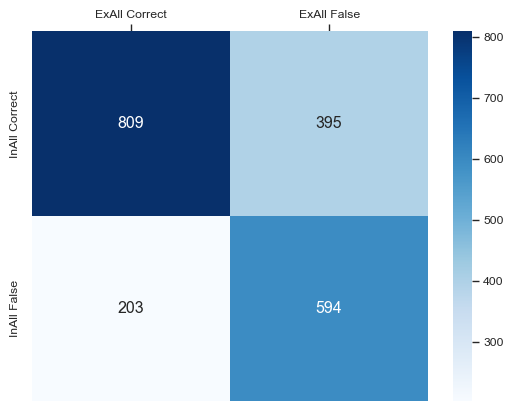

In [167]:
import matplotlib.pyplot as plt
import numpy as np


# Define the 2x2 matrix
best_case = results['dmg777k+InAll$TransE$KNN']
matrix = np.array([[best_case['a'],best_case['b']],[best_case['c'],best_case['d']]])
matrix_df = pd.DataFrame(matrix,columns=['ExAll Correct','ExAll False'], index=['InAll Correct','InAll False'],dtype=np.int32)
# Define the labels for the rows and columns
# row_labels = ['Condition A', 'Condition B']
# col_labels = ['Condition A', 'Condition B']

# # Create a figure and an axis
fig, ax = plt.subplots()

sns.heatmap(matrix_df,annot=True , fmt=".0f", cmap="Blues",ax=ax,annot_kws={'fontsize':'larger'},fontsize=14)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
path= '../docs/plots/'
# import tikzplotlib
# tikzplotlib.save(f'{path}heatmap1.tex')
plt.savefig(f'{path}heatmap.pgf', format='pgf', backend='pgf')

# heatmap = ax.pcolor(matrix[::-1], cmap='Blues')  # Reverse the matrix to have "true true" at the top left corner
# # Add colorbar
# # cbar = plt.colorbar(heatmap)
# # Add labels to each cell
# for i in range(matrix.shape[0]):
#     for j in range(matrix.shape[1]):
#         ax.text(j + 0.5, i + 0.5, matrix[::-1][i, j], ha='center', va='center')

# # Set the ticks in the middle of the cells
# ax.set_xticks(np.arange(matrix.shape[1]) + 0.5, minor=False)
# ax.set_yticks(np.arange(matrix.shape[0]) + 0.5, minor=False)

# # Add the labels on top
# ax.set_xticklabels(col_labels, ha='center')  # Align the labels to the left
# ax.set_yticklabels(row_labels[::-1], va='center')  # Reverse and align the labels to the bottom
# # ax.invert_yaxis()
# ax.xaxis.tick_top()

# # Add colorbar
# cbar = plt.colorbar(heatmap)



# Show the plot
plt.show()

In [155]:
matrix_df

,ExAll Correct,ExAll False
InAll Correct,809,395
InAll False,203,594


In [388]:
get_pivot_of_df(df, values='pct_acc_delta', columns='dataset', index=['augment'] ).round(3)

dataset,amplus,dmg777k,dmgfull,mdgenre
augment,,,,
ExAll,0.000,0.000,0.000,0.000
InAll,8.633,11.015,-1.836,-1.238
OneEntPerRel,9.240,5.492,0.600,-0.922


In [389]:
get_pivot_of_df(df, values='pct_acc_delta', columns='embedder', index=['augment'] ).round(3)

embedder,DistMult,RDF2Vec,TransE
augment,,,
ExAll,0.000,0.000,0.000
InAll,0.356,5.022,7.053
OneEntPerRel,0.181,3.393,7.234


In [387]:
get_pivot_of_df(df, values='pct_acc_delta', columns='dataset', index=['augment'] ).mean(axis=1).round(3)

augment
ExAll           0.000
InAll           4.144
OneEntPerRel    3.602
dtype: float64

In [375]:
get_pivot_of_df(df, values='acc', columns='dataset', index=['augment'] ).mean(axis=1).round(3)

augment
ExAll           0.600
InAll           0.622
OneEntPerRel    0.620
dtype: float64

In [414]:
get_pivot_of_df(df, values='d', columns='dataset', index=['augment'] ).mean(axis=1).round(0)

augment
ExAll           4401.0
InAll           3369.0
OneEntPerRel    3334.0
dtype: float64

In [407]:
get_pivot_of_df(df, values='d', columns='dataset', index=['augment'], aggfunc="sum" ).sum(axis=1).round(3)

augment
ExAll           105614.0
InAll            80857.0
OneEntPerRel     80017.0
dtype: float64

In [409]:
mc= mcnemar([[144759, 24757], [19633, 80857]], exact=False,correction=True)
print(mc)

pvalue      1.3466771451589468e-130
statistic   591.239671097094


In [401]:
get_pivot_of_df(df, values='pvalue', columns='dataset', index=['augment'], ).mean(axis=1).round(3)

augment
ExAll           0.000
InAll           0.063
OneEntPerRel    0.129
dtype: float64

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
matplotlib.use('pgf')

# Define the 2x2 matrix
best_case = results['dmg777k+InAll$TransE$KNN']
matrix = np.array([[best_case['a'],best_case['b']],[best_case['c'],best_case['d']]])

# Define the labels for the rows and columns
row_labels = ['InAll Correct', 'InAll False']
col_labels = ['ExAll Correct', 'ExAll False']

# Create a figure and an axis
fig, ax = plt.subplots()

heatmap = ax.pcolor(matrix[::-1], cmap='Blues')  # Reverse the matrix to have "true true" at the top left corner
# Add colorbar
# cbar = plt.colorbar(heatmap)
# Add labels to each cell
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j + 0.5, i + 0.5, matrix[::-1][i, j], ha='center', va='center')

# Set the ticks in the middle of the cells
ax.set_xticks(np.arange(matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0]) + 0.5, minor=False)

# Add the labels on top
ax.set_xticklabels(col_labels, ha='center')  # Align the labels to the left
ax.set_yticklabels(row_labels[::-1], va='center')  # Reverse and align the labels to the bottom
# ax.invert_yaxis()
ax.xaxis.tick_top()
# Add colorbar
cbar = plt.colorbar(heatmap)


tikzplotlib.save("../docs/plots/1.tex")
# Show the plot
# plt.show()
# plt.savefig('../docs/plots/1.pgf', backend='pgf',  format='pgf' )

In [7]:
aug_approaches = [ 'ExAll','InDates', 'InImages', 'InNumbers',
       'InText']

In [65]:
re.search(r'[dD]ate', 'hallodate')

<re.Match object; span=(5, 9), match='date'>

In [78]:
plot_violin(df,aug_approaches,'baseline_methods')

result: InAll* - 65.0 - 0.013779282569885254
result: OneEntPerRel* - 76.0 - 0.033985137939453125


{'InAll': 0.013779282569885254, 'OneEntPerRel': 0.033985137939453125}

In [79]:
plot_violin(df,in_app,'include_x')

result: InDates$^{ns}$ - 32.0 - 0.6220703125
result: InImages$^{ns}$ - 81.0 - 0.08262388095074862
result: InNumbers$^{ns}$ - 141.0 - 0.8115357160568237
result: InText$^{ns}$ - 42.0 - 0.1022419711196503


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


{'InDates': 0.6220703125,
 'InImages': 0.08262388095074862,
 'InNumbers': 0.8115357160568237,
 'InText': 0.1022419711196503}

## InX

In [47]:
in_app = [ 'ExAll','InDates', 'InImages', 'InNumbers',
       'InText']

In [80]:
results_as_latex(df, aug_approaches=in_app, name="Include X")
get_pivot_of_df(df,aug_approaches=in_app)

dataset            amplus        dmg777k        dmgfull        mdgenre       
eval_method           KNN    SVM     KNN    SVM     KNN    SVM     KNN    SVM
embedder augment                                                             
DistMult ExAll      0.458  0.512   0.548  0.542   0.619  0.658   0.605  0.622
         InDates    0.375  0.445     NaN    NaN     NaN    NaN   0.604  0.627
         InImages   0.332  0.410   0.515  0.544   0.556  0.657   0.594  0.617
         InNumbers  0.430  0.465   0.542  0.561   0.557  0.655   0.618  0.627
         InText     0.458  0.512   0.568  0.558   0.625  0.641   0.551  0.594
RDF2Vec  ExAll      0.550  0.536   0.586  0.606   0.629  0.661   0.590  0.662
         InDates    0.599  0.621     NaN    NaN     NaN    NaN   0.579  0.663
         InImages   0.556  0.540   0.606  0.599   0.627  0.654   0.586  0.664
         InNumbers  0.551  0.558   0.604  0.590   0.627  0.647   0.598  0.664
         InText     0.550  0.536   0.632  0.628   0.629  0.656   0.595  0.664
TransE   ExAll      0.682  0.708   0.506  0.528   0.649  0.662   0.634  0.646
         InDates    0.700  0.735     NaN    NaN     NaN    NaN   0.635  0.645
         InImages   0.679  0.708   0.505  0.544   0.647  0.668   0.630  0.640
         InNumbers  0.711  0.733   0.490  0.521   0.646  0.663   0.636  0.642
         InText     0.682  0.708   0.571  0.601   0.656  0.676   0.637  0.651

In [427]:
get_pivot_of_df(df,aug_approaches=in_app,  values='f1_macro')

dataset            amplus        dmg777k        dmgfull        mdgenre       
eval_method           KNN    SVM     KNN    SVM     KNN    SVM     KNN    SVM
embedder augment                                                             
DistMult ExAll      0.206  0.304   0.352  0.366   0.187  0.253   0.140  0.163
         InDates    0.180  0.181   0.352  0.366   0.187  0.253   0.134  0.156
         InImages   0.125  0.121   0.353  0.350   0.171  0.254   0.128  0.149
         InNumbers  0.150  0.241   0.347  0.356   0.178  0.249   0.162  0.154
         InText     0.206  0.304   0.418  0.442   0.211  0.215   0.068  0.105
RDF2Vec  ExAll      0.348  0.278   0.440  0.527   0.204  0.230   0.184  0.200
         InDates    0.353  0.329   0.439  0.507   0.204  0.230   0.190  0.203
         InImages   0.330  0.266   0.438  0.490   0.201  0.220   0.189  0.201
         InNumbers  0.324  0.275   0.450  0.505   0.214  0.222   0.183  0.202
         InText     0.348  0.278   0.480  0.537   0.217  0.226   0.183  0.201
TransE   ExAll      0.478  0.532   0.304  0.335   0.250  0.243   0.189  0.165
         InDates    0.506  0.576   0.304  0.335   0.250  0.243   0.195  0.177
         InImages   0.495  0.539   0.305  0.348   0.266  0.299   0.184  0.159
         InNumbers  0.521  0.576   0.287  0.317   0.244  0.243   0.207  0.183
         InText     0.478  0.532   0.395  0.426   0.287  0.309   0.185  0.176

In [426]:
get_pivot_of_df(df,aug_approaches=in_app,  values='p_test_passed')

dataset            amplus      dmg777k      dmgfull      mdgenre     
eval_method           KNN  SVM     KNN  SVM     KNN  SVM     KNN  SVM
embedder augment                                                     
DistMult ExAll        1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         InDates      1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0
         InImages     1.0  1.0     1.0  0.0     1.0  0.0     1.0  0.0
         InNumbers    1.0  1.0     0.0  0.0     1.0  0.0     1.0  0.0
         InText       1.0  1.0     0.0  0.0     1.0  1.0     1.0  1.0
RDF2Vec  ExAll        1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         InDates      1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0
         InImages     1.0  0.0     1.0  0.0     0.0  1.0     0.0  0.0
         InNumbers    0.0  1.0     0.0  0.0     0.0  1.0     0.0  0.0
         InText       1.0  1.0     1.0  1.0     0.0  1.0     0.0  0.0
TransE   ExAll        1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         InDates      1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0
         InImages     0.0  0.0     0.0  0.0     0.0  1.0     0.0  0.0
         InNumbers    1.0  1.0     0.0  0.0     0.0  0.0     0.0  0.0
         InText       1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0

In [431]:
get_pivot_of_df(df,aug_approaches=in_app,  values='pvalue').round(5)

dataset              amplus           dmg777k           dmgfull           \
eval_method             KNN      SVM      KNN      SVM      KNN      SVM   
embedder augment                                                           
DistMult ExAll      0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
         InDates    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
         InImages   0.00000  0.00000  0.00088  0.83416  0.00000  0.54283   
         InNumbers  0.00000  0.00000  0.57154  0.05464  0.00000  0.05596   
         InText     0.00000  0.00000  0.07277  0.17514  0.01016  0.00000   
RDF2Vec  ExAll      0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
         InDates    0.00000  0.00000  0.02886  0.00329  0.00000  0.00000   
         InImages   0.03672  0.09387  0.03496  0.47322  0.14219  0.00007   
         InNumbers  0.98453  0.00000  0.05040  0.10229  0.28746  0.00000   
         InText     0.00000  0.00000  0.00000  0.03276  1.00000  0.00957   
TransE   ExAll      0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
         InDates    0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
         InImages   0.22904  0.98548  1.00000  0.21874  0.51389  0.04650   
         InNumbers  0.00000  0.00000  0.15274  0.56666  0.24693  0.74028   
         InText     0.00000  0.00000  0.00000  0.00000  0.00449  0.00000   

dataset             mdgenre           
eval_method             KNN      SVM  
embedder augment                      
DistMult ExAll      0.00000  0.00000  
         InDates    0.93850  0.34632  
         InImages   0.01192  0.42779  
         InNumbers  0.00466  0.28397  
         InText     0.00000  0.00000  
RDF2Vec  ExAll      0.00000  0.00000  
         InDates    0.05840  0.74342  
         InImages   0.46103  0.59816  
         InNumbers  0.12828  0.51518  
         InText     0.41832  0.58977  
TransE   ExAll      0.00000  0.00000  
         InDates    0.82681  0.93850  
         InImages   0.45730  0.23859  
         InNumbers  0.77565  0.41992  
         InText     0.51600  0.24716

In [424]:
get_pivot_of_df(df, values='pct_acc_delta', columns='dataset', index=['augment'], aug_approaches=in_app ).round(3)

dataset,amplus,dmg777k,dmgfull,mdgenre
augment,,,,
ExAll,0.000,0.000,0.000,0.000
InDates,0.002,-0.201,0.000,-0.179
InImages,-7.673,-0.094,-1.851,-0.760
InNumbers,-0.537,-0.274,-2.203,0.718
InText,0.000,7.459,0.137,-1.838


In [439]:

results_as_latex2(df, aug_approaches=[*ex_app,*in_app], name="Baseline Results", values='pct_acc_delta', columns='dataset', index=['augment'])
get_pivot_of_df(df, values='pct_acc_delta', columns='dataset', index=['augment'], aug_approaches=[*ex_app,*in_app] ).round(3)

dataset,amplus,dmg777k,dmgfull,mdgenre
augment,,,,
ExAll,0.000,0.000,0.000,0.000
ExDates,2.256,11.025,-1.811,-0.719
ExImages,10.756,10.164,-1.374,-1.009
ExNumbers,4.627,13.013,-1.703,-2.034
ExText,-9.373,3.510,-6.218,-0.955
InAll,8.633,11.015,-1.836,-1.238
InDates,0.002,-0.201,0.000,-0.179
InImages,-7.673,-0.094,-1.851,-0.760
InNumbers,-0.537,-0.274,-2.203,0.718


## Exclude x

In [83]:
ex_app = [ 'ExAll','ExDates', 'ExImages', 'ExNumbers',
       'ExText']

In [84]:
results_as_latex(df, aug_approaches=ex_app, name="Exclude X")
get_pivot_of_df(df,aug_approaches=ex_app, values='acc')

dataset            amplus        dmg777k        dmgfull        mdgenre       
eval_method           KNN    SVM     KNN    SVM     KNN    SVM     KNN    SVM
embedder augment                                                             
DistMult ExAll      0.458  0.512   0.548  0.542   0.619  0.658   0.605  0.622
         ExDates    0.446  0.490     NaN    NaN     NaN    NaN   0.594  0.622
         ExImages   0.520  0.570   0.585  0.595   0.562  0.584   0.591  0.617
         ExNumbers  0.427  0.490   0.607  0.627   0.565  0.579   0.571  0.604
         ExText     0.332  0.354   0.484  0.579   0.576  0.592   0.588  0.608
RDF2Vec  ExAll      0.550  0.536   0.586  0.606   0.629  0.661   0.590  0.662
         ExDates    0.582  0.582     NaN    NaN     NaN    NaN   0.578  0.661
         ExImages   0.609  0.611   0.626  0.627   0.637  0.687   0.580  0.662
         ExNumbers  0.616  0.629   0.619  0.635   0.634  0.688   0.582  0.661
         ExText     0.691  0.681   0.605  0.606   0.611  0.629   0.585  0.662
TransE   ExAll      0.682  0.708   0.506  0.528   0.649  0.662   0.634  0.646
         ExDates    0.704  0.728     NaN    NaN     NaN    NaN   0.633  0.645
         ExImages   0.731  0.763   0.607  0.603   0.667  0.690   0.634  0.638
         ExNumbers  0.711  0.745   0.612  0.635   0.663  0.685   0.628  0.638
         ExText     0.526  0.512   0.568  0.583   0.619  0.609   0.641  0.640

In [133]:
plot_violin(df,ex_app,'exclude_x')

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


result: ExDates$^{ns}$ - 30.0 - 0.7891658873743511
result: ExImages** - 46.5 - 0.009387934426472228
result: ExNumbers$^{ns}$ - 93.0 - 0.10738253593444824
result: ExText$^{ns}$ - 84.0 - 0.16765127087714093


{'ExDates': 0.7891658873743511,
 'ExImages': 0.009387934426472228,
 'ExNumbers': 0.10738253593444824,
 'ExText': 0.16765127087714093}

In [443]:
get_pivot_of_df(df,aug_approaches=ex_app,  values='pvalue').round(5)

dataset              amplus       dmg777k           dmgfull       mdgenre  \
eval_method             KNN  SVM      KNN      SVM      KNN  SVM      KNN   
embedder augment                                                            
DistMult ExAll      0.00000  0.0  0.00000  0.00000  0.00000  0.0  0.00000   
         ExDates    0.00195  0.0  0.00008  0.00000  0.00000  0.0  0.02015   
         ExImages   0.00000  0.0  0.00189  0.00001  0.00000  0.0  0.00458   
         ExNumbers  0.00000  0.0  0.00000  0.00000  0.00000  0.0  0.00000   
         ExText     0.00000  0.0  0.00000  0.00165  0.00000  0.0  0.00028   
         InAll      0.00000  0.0  0.00008  0.00000  0.00000  0.0  0.00000   
RDF2Vec  ExAll      0.00000  0.0  0.00000  0.00000  0.00000  0.0  0.00000   
         ExDates    0.00000  0.0  0.00000  0.30932  0.01399  0.0  0.05003   
         ExImages   0.00000  0.0  0.00012  0.04794  0.00114  0.0  0.09735   
         ExNumbers  0.00000  0.0  0.00176  0.00418  0.03952  0.0  0.20926   
         ExText     0.00000  0.0  0.08383  0.96542  0.00000  0.0  0.39117   
         InAll      0.00000  0.0  0.00017  0.03829  0.01736  0.0  0.25980   
TransE   ExAll      0.00000  0.0  0.00000  0.00000  0.00000  0.0  0.00000   
         ExDates    0.00000  0.0  0.00000  0.00000  0.00000  0.0  0.82402   
         ExImages   0.00000  0.0  0.00000  0.00000  0.00000  0.0  1.00000   
         ExNumbers  0.00000  0.0  0.00000  0.00000  0.00000  0.0  0.22912   
         ExText     0.00000  0.0  0.00000  0.00001  0.00000  0.0  0.14786   
         InAll      0.00000  0.0  0.00000  0.00000  0.00000  0.0  0.29537   

dataset                      
eval_method             SVM  
embedder augment             
DistMult ExAll      0.00000  
         ExDates    1.00000  
         ExImages   0.40139  
         ExNumbers  0.00053  
         ExText     0.01479  
         InAll      0.02592  
RDF2Vec  ExAll      0.00000  
         ExDates    0.91785  
         ExImages   0.91511  
         ExNumbers  0.82624  
         ExText     1.00000  
         InAll      0.29451  
TransE   ExAll      0.00000  
         ExDates    1.00000  
         ExImages   0.23747  
         ExNumbers  0.20777  
         ExText     0.39877  
         InAll      0.58664

In [97]:
results_as_latex(df, aug_approaches=[*aug_approaches,*in_app,*ex_app],  values='pct_acc_delta', columns='dataset', index='augment', name="Mean Percentual Performance Gains")
get_pivot_of_df(df,aug_approaches=[*aug_approaches,*in_app,*ex_app],  values='pct_acc_delta', columns='dataset', index='augment').round(3)

dataset,amplus,dmg777k,dmgfull,mdgenre
augment,,,,
ExAll,0.000,0.000,0.000,0.000
ExDates,2.256,NaN,NaN,-0.719
ExImages,10.756,10.164,-1.374,-1.009
ExNumbers,4.627,13.013,-1.703,-2.034
ExText,-9.373,3.510,-6.218,-0.955
InAll,8.633,11.015,-1.836,-1.238
InDates,0.002,NaN,NaN,-0.179
InImages,-7.673,-0.094,-1.851,-0.760
InNumbers,-0.537,-0.274,-2.203,0.718


# Binning

## normal bins

In [64]:
normal_bins = ['ExAll', '5_bins', '10_bins','100_bins']

In [136]:
results_as_latex(df, aug_approaches=normal_bins, name="Regular Binning")
plot_violin(df,normal_bins, name="Regular Binning")
get_pivot_of_df(df,aug_approaches=normal_bins, values='acc')


result: 5bins$^{ns}$ - 87.0 - 0.07379257678985596
result: 10bins* - 69.0 - 0.019441962242126465
result: 100bins* - 51.5 - 0.014789447910343399


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


dataset           amplus        dmg777k        dmgfull        mdgenre       
eval_method          KNN    SVM     KNN    SVM     KNN    SVM     KNN    SVM
embedder augment                                                            
DistMult 100_bins  0.458  0.492   0.538  0.561   0.570  0.650   0.601  0.626
         10_bins   0.451  0.497   0.529  0.543   0.593  0.645   0.615  0.629
         5_bins    0.443  0.470   0.542  0.569   0.594  0.653   0.617  0.633
         ExAll     0.458  0.512   0.548  0.542   0.619  0.658   0.605  0.622
RDF2Vec  100_bins  0.498  0.501   0.603  0.579   0.627  0.651   0.583  0.661
         10_bins   0.465  0.498   0.605  0.595   0.630  0.643   0.580  0.661
         5_bins    0.466  0.503   0.595  0.613   0.627  0.653   0.589  0.660
         ExAll     0.550  0.536   0.586  0.606   0.629  0.661   0.590  0.662
TransE   100_bins  0.678  0.706   0.461  0.475   0.656  0.666   0.634  0.644
         10_bins   0.677  0.703   0.500  0.521   0.643  0.667   0.639  0.651
         5_bins    0.680  0.704   0.483  0.478   0.644  0.665   0.636  0.643
         ExAll     0.682  0.708   0.506  0.528   0.649  0.662   0.634  0.646

In [148]:
plot_violin(df,aug_approaches, name="aa",measure='f1_macro')

result: InAll* - 70.0 - 0.02112710475921631
result: OneEntPerRel* - 64.0 - 0.012604832649230957


{'InAll': 0.02112710475921631, 'OneEntPerRel': 0.012604832649230957}

In [153]:
plot_violin(df,[*normal_bins,*aug_approaches[1:],*kga_approaches[1:]], name="f1many",measure='f1_macro')

result: 5 bins$^{ns}$ - 111.5 - 0.28966712951660156
result: 10 bins$^{ns}$ - 143.0 - 0.8553357124328613
result: 100 bins$^{ns}$ - 129.0 - 0.7842034081920457
result: InAll* - 70.0 - 0.02112710475921631
result: OneEntPerRel* - 64.0 - 0.012604832649230957
result: 100 overlapping$^{ns}$ - 143.5 - 0.8553357124328613
result: 10 overlapping$^{ns}$ - 137.0 - 0.7257407903671265
result: 5 10 100 hierarchy$^{ns}$ - 119.5 - 0.3902466297149658
result: 5lvl binary hierarchy$^{ns}$ - 130.5 - 0.6033114194869995


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


{'5_bins': 0.28966712951660156,
 '10_bins': 0.8553357124328613,
 '100_bins': 0.7842034081920457,
 'InAll': 0.02112710475921631,
 'OneEntPerRel': 0.012604832649230957,
 '100_overlapping': 0.8553357124328613,
 '10_overlapping': 0.7257407903671265,
 '5_10_100_hierarchy': 0.3902466297149658,
 '5lvl_binary_hierarchy': 0.6033114194869995}

In [141]:
get_pivot_of_df(df,aug_approaches=normal_bins, values='p_test_passed')

dataset           amplus      dmg777k      dmgfull      mdgenre     
eval_method          KNN  SVM     KNN  SVM     KNN  SVM     KNN  SVM
embedder augment                                                    
DistMult 100_bins    0.0  1.0     0.0  0.0     1.0  1.0     0.0  0.0
         10_bins     0.0  1.0     1.0  0.0     1.0  1.0     1.0  0.0
         5_bins      1.0  1.0     0.0  1.0     1.0  1.0     1.0  1.0
         ExAll       1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
RDF2Vec  100_bins    1.0  1.0     0.0  1.0     0.0  1.0     0.0  0.0
         10_bins     1.0  1.0     1.0  0.0     0.0  1.0     0.0  0.0
         5_bins      1.0  1.0     0.0  0.0     0.0  1.0     0.0  0.0
         ExAll       1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
TransE   100_bins    0.0  0.0     1.0  1.0     1.0  0.0     0.0  0.0
         10_bins     0.0  0.0     0.0  0.0     1.0  0.0     0.0  0.0
         5_bins      0.0  0.0     0.0  1.0     0.0  0.0     0.0  0.0
         ExAll       1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0

In [106]:
plot_violin(df,normal_bins,'Regular Binning')

result: 5_bins$^{ns}$ - 87.0 - 0.07379257678985596
result: 10_bins* - 69.0 - 0.019441962242126465
result: 100_bins* - 51.5 - 0.014789447910343399


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


{'5_bins': 0.07379257678985596,
 '10_bins': 0.019441962242126465,
 '100_bins': 0.014789447910343399}

## % bins

In [103]:
df['augment'].unique()

array(['100_bins', '100_lof_bins', '100_overlapping', '10_bins',
       '10_lof_bins', '10_overlapping', '10_pct_bins', '1_pct_bins',
       '5_10_100_hierarchy', '5_bins', '5_lof_bins', '5_pct_bins',
       '5lvl_binary_hierarchy', 'ExAll', 'ExDates', 'ExImages',
       'ExNumbers', 'ExText', 'InAll', 'InDates', 'InImages', 'InNumbers',
       'InText', 'LDA_topics', 'OneEntPerRel', 'VGG_classes',
       'date_binning', 'date_features', 'propConst', 'propConst_LOF',
       'propValConst', 'propValConst_LOF', 'testbins'], dtype=object)

In [65]:
pct_bins = ['ExAll', '1_pct_bins', '5_pct_bins','10_pct_bins']

In [105]:
results_as_latex(df, aug_approaches=pct_bins, name="Percent Binning")
get_pivot_of_df(df,aug_approaches=pct_bins, values='acc')

dataset              amplus        dmg777k        dmgfull        mdgenre  \
eval_method             KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                           
DistMult 10_pct_bins  0.391  0.444   0.533  0.558   0.558  0.651   0.613   
         1_pct_bins   0.391  0.444   0.533  0.558   0.558  0.651   0.613   
         5_pct_bins   0.391  0.444   0.533  0.558   0.558  0.651   0.613   
         ExAll        0.458  0.512   0.548  0.542   0.619  0.658   0.605   
RDF2Vec  10_pct_bins  0.493  0.502   0.596  0.605   0.628  0.653   0.585   
         1_pct_bins   0.493  0.502   0.596  0.605   0.628  0.653   0.585   
         5_pct_bins   0.493  0.502   0.596  0.605   0.628  0.653   0.585   
         ExAll        0.550  0.536   0.586  0.606   0.629  0.661   0.590   
TransE   10_pct_bins  0.675  0.698   0.508  0.523   0.658  0.669   0.641   
         1_pct_bins   0.675  0.698   0.508  0.523   0.658  0.669   0.641   
         5_pct_bins   0.675  0.698   0.508  0.523   0.658  0.669   0.641   
         ExAll        0.682  0.708   0.506  0.528   0.649  0.662   0.634   

dataset                      
eval_method             SVM  
embedder augment             
DistMult 10_pct_bins  0.632  
         1_pct_bins   0.632  
         5_pct_bins   0.632  
         ExAll        0.622  
RDF2Vec  10_pct_bins  0.665  
         1_pct_bins   0.665  
         5_pct_bins   0.665  
         ExAll        0.662  
TransE   10_pct_bins  0.649  
         1_pct_bins   0.649  
         5_pct_bins   0.649  
         ExAll        0.646

In [108]:
plot_violin(df,pct_bins,'Percent Binning')

result: 1_pct_bins$^{ns}$ - 108.5 - 0.2522493600845337
result: 5_pct_bins$^{ns}$ - 108.5 - 0.2522493600845337
result: 10_pct_bins$^{ns}$ - 108.5 - 0.2522493600845337


{'1_pct_bins': 0.2522493600845337,
 '5_pct_bins': 0.2522493600845337,
 '10_pct_bins': 0.2522493600845337}

## KGA approaches

In [118]:
kga_approaches= ["ExAll","100_overlapping", "10_overlapping", '5_10_100_hierarchy', "5lvl_binary_hierarchy"]

result: 100 overlapping* - 80.5 - 0.04906117916107178
result: 10 overlapping* - 58.0 - 0.01489067198699634
result: 5 10 100 hierarchy$^{ns}$ - 89.0 - 0.08392000198364258
result: 5lvl binary hierarchy$^{ns}$ - 85.5 - 0.06910169124603271


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


dataset                        amplus        dmg777k        dmgfull         \
eval_method                       KNN    SVM     KNN    SVM     KNN    SVM   
embedder augment                                                             
DistMult 100_overlapping        0.457  0.482   0.505  0.543   0.633  0.655   
         10_overlapping         0.460  0.501   0.509  0.523   0.598  0.650   
         5_10_100_hierarchy     0.495  0.521   0.393  0.386   0.640  0.664   
         5lvl_binary_hierarchy  0.487  0.524   0.342  0.370   0.660  0.676   
         ExAll                  0.458  0.512   0.548  0.542   0.619  0.658   
RDF2Vec  100_overlapping        0.474  0.498   0.595  0.582   0.628  0.656   
         10_overlapping         0.458  0.474   0.603  0.556   0.626  0.652   
         5_10_100_hierarchy     0.411  0.436   0.601  0.540   0.619  0.636   
         5lvl_binary_hierarchy  0.378  0.478   0.595  0.544   0.617  0.641   
         ExAll                  0.550  0.536   0.586  0.606   0.629  0.661   
TransE   100_overlapping        0.678  0.705   0.455  0.448   0.651  0.673   
         10_overlapping         0.681  0.707   0.486  0.517   0.643  0.668   
         5_10_100_hierarchy     0.684  0.699   0.396  0.436   0.648  0.672   
         5lvl_binary_hierarchy  0.685  0.702   0.377  0.381   0.640  0.656   
         ExAll                  0.682  0.708   0.506  0.528   0.649  0.662   

dataset                        mdgenre         
eval_method                        KNN    SVM  
embedder augment                               
DistMult 100_overlapping         0.618  0.627  
         10_overlapping          0.610  0.637  
         5_10_100_hierarchy      0.607  0.623  
         5lvl_binary_hierarchy   0.618  0.631  
         ExAll                   0.605  0.622  
RDF2Vec  100_overlapping         0.584  0.660  
         10_overlapping          0.590  0.663  
         5_10_100_hierarchy      0.568  0.660  
         5lvl_binary_hierarchy   0.560  0.659  
         ExAll                   0.590  0.662  
TransE   100_overlapping         0.632  0.642  
         10_overlapping          0.629  0.647  
         5_10_100_hierarchy      0.639  0.641  
         5lvl_binary_hierarchy   0.631  0.641  
         ExAll                   0.634  0.646

<Figure size 640x480 with 0 Axes>

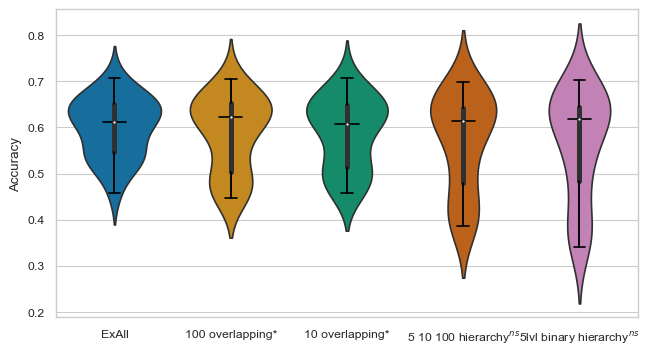

In [119]:
results_as_latex(df, aug_approaches=kga_approaches, name="KGA Based")
plot_violin(df,kga_approaches, name="KGA Based")
get_pivot_of_df(df,aug_approaches=kga_approaches, values='acc')


In [ ]:
plot_violin(df,kga_approaches, name="KGA Based",measure='f1_macro')

In [143]:
get_pivot_of_df(df,aug_approaches=kga_approaches, values='p_test_passed')

dataset                        amplus      dmg777k      dmgfull      mdgenre  \
eval_method                       KNN  SVM     KNN  SVM     KNN  SVM     KNN   
embedder augment                                                               
DistMult 100_overlapping          0.0  1.0     1.0  0.0     1.0  0.0     1.0   
         10_overlapping           0.0  1.0     1.0  0.0     1.0  1.0     0.0   
         5_10_100_hierarchy       1.0  1.0     1.0  1.0     1.0  1.0     0.0   
         5lvl_binary_hierarchy    1.0  1.0     1.0  1.0     1.0  1.0     1.0   
         ExAll                    1.0  1.0     1.0  1.0     1.0  1.0     1.0   
RDF2Vec  100_overlapping          1.0  1.0     0.0  1.0     0.0  1.0     0.0   
         10_overlapping           1.0  1.0     0.0  1.0     0.0  1.0     0.0   
         5_10_100_hierarchy       1.0  1.0     0.0  1.0     1.0  1.0     1.0   
         5lvl_binary_hierarchy    1.0  1.0     0.0  1.0     1.0  1.0     1.0   
         ExAll                    1.0  1.0     1.0  1.0     1.0  1.0     1.0   
TransE   100_overlapping          0.0  0.0     1.0  1.0     0.0  1.0     0.0   
         10_overlapping           0.0  0.0     0.0  0.0     1.0  1.0     0.0   
         5_10_100_hierarchy       0.0  1.0     1.0  1.0     0.0  1.0     0.0   
         5lvl_binary_hierarchy    0.0  1.0     1.0  1.0     1.0  1.0     0.0   
         ExAll                    1.0  1.0     1.0  1.0     1.0  1.0     1.0   

dataset                              
eval_method                     SVM  
embedder augment                     
DistMult 100_overlapping        0.0  
         10_overlapping         1.0  
         5_10_100_hierarchy     0.0  
         5lvl_binary_hierarchy  0.0  
         ExAll                  1.0  
RDF2Vec  100_overlapping        0.0  
         10_overlapping         0.0  
         5_10_100_hierarchy     0.0  
         5lvl_binary_hierarchy  0.0  
         ExAll                  1.0  
TransE   100_overlapping        0.0  
         10_overlapping         0.0  
         5_10_100_hierarchy     0.0  
         5lvl_binary_hierarchy  0.0  
         ExAll                  1.0

In [146]:
plot_violin(df,kga_approaches, name="KGA Based",measure='f1_macro')

result: 100 overlapping$^{ns}$ - 143.5 - 0.8553357124328613
result: 10 overlapping$^{ns}$ - 137.0 - 0.7257407903671265
result: 5 10 100 hierarchy$^{ns}$ - 119.5 - 0.3902466297149658
result: 5lvl binary hierarchy$^{ns}$ - 130.5 - 0.6033114194869995


{'100_overlapping': 0.8553357124328613,
 '10_overlapping': 0.7257407903671265,
 '5_10_100_hierarchy': 0.3902466297149658,
 '5lvl_binary_hierarchy': 0.6033114194869995}

## Outlier aware

In [66]:
outlier_approaches = ["ExAll", "5_lof_bins", "10_lof_bins", "100_lof_bins"]

In [156]:
results_as_latex(df, aug_approaches=outlier_approaches, name="LOF")
plot_violin(df,outlier_approaches, name="LOF")
get_pivot_of_df(df,aug_approaches=outlier_approaches, values='acc')

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


result: 5 lof bins$^{ns}$ - 74.5 - 0.09105005648544394
result: 10 lof bins$^{ns}$ - 100.0 - 0.5895575696483077
result: 100 lof bins$^{ns}$ - 129.5 - 0.5645889043807983


dataset               amplus        dmg777k        dmgfull        mdgenre  \
eval_method              KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                            
DistMult 100_lof_bins  0.476  0.507   0.512  0.537   0.627  0.664   0.613   
         10_lof_bins   0.486  0.517   0.532  0.541   0.614  0.659   0.624   
         5_lof_bins    0.468  0.511   0.520  0.548   0.610  0.651   0.606   
         ExAll         0.458  0.512   0.548  0.542   0.619  0.658   0.605   
RDF2Vec  100_lof_bins  0.514  0.540   0.595  0.619   0.625  0.643   0.585   
         10_lof_bins   0.480  0.499   0.603  0.572   0.627  0.657   0.590   
         5_lof_bins    0.476  0.488   0.611  0.591   0.629  0.655   0.590   
         ExAll         0.550  0.536   0.586  0.606   0.629  0.661   0.590   
TransE   100_lof_bins  0.705  0.723   0.498  0.508   0.653  0.668   0.642   
         10_lof_bins   0.682  0.710   0.495  0.521   0.650  0.664   0.634   
         5_lof_bins    0.684  0.704   0.493  0.508   0.647  0.667   0.632   
         ExAll         0.682  0.708   0.506  0.528   0.649  0.662   0.634   

dataset                       
eval_method              SVM  
embedder augment              
DistMult 100_lof_bins  0.627  
         10_lof_bins   0.636  
         5_lof_bins    0.621  
         ExAll         0.622  
RDF2Vec  100_lof_bins  0.661  
         10_lof_bins   0.667  
         5_lof_bins    0.663  
         ExAll         0.662  
TransE   100_lof_bins  0.647  
         10_lof_bins   0.644  
         5_lof_bins    0.649  
         ExAll         0.646

In [160]:
plot_violin(df,outlier_approaches, name="LOF f1", measure='f1_macro')

result: 5 lof bins$^{ns}$ - 136.5 - 0.704756498336792
result: 10 lof bins$^{ns}$ - 112.5 - 0.28966712951660156
result: 100 lof bins** - 54.0 - 0.004810690879821777


C:\Users\Noctris\AppData\Local\Temp\ipykernel_6384\3054771138.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7.5,4))


{'5_lof_bins': 0.704756498336792,
 '10_lof_bins': 0.28966712951660156,
 '100_lof_bins': 0.004810690879821777}

In [46]:
get_pivot_of_df(df,aug_approaches=outlier_approaches, values='pvalue')

dataset                       amplus                 dmg777k            \
eval_method                      KNN           SVM       KNN       SVM   
embedder augment                                                         
DistMult 100_lof_bins   2.566049e-07  2.097518e-01  0.000360  0.689524   
         10_lof_bins    3.613555e-16  1.313233e-01  0.109887  0.964400   
         5_lof_bins     4.140335e-03  8.906535e-01  0.006735  0.615612   
         ExAll          0.000000e+00  0.000000e+00  0.000000  0.000000   
RDF2Vec  100_lof_bins   1.293797e-35  1.013810e-01  0.327956  0.217651   
         10_lof_bins   1.108511e-128  1.696335e-57  0.063223  0.000462   
         5_lof_bins    3.366054e-142  4.347674e-92  0.007337  0.127457   
         ExAll          0.000000e+00  0.000000e+00  0.000000  0.000000   
TransE   100_lof_bins   1.439316e-16  8.645634e-08  0.509856  0.109599   
         10_lof_bins    9.848736e-01  4.964579e-01  0.361810  0.588048   
         5_lof_bins     3.300334e-01  2.165827e-01  0.263552  0.112538   
         ExAll          0.000000e+00  0.000000e+00  0.000000  0.000000   

dataset                 dmgfull                 mdgenre            
eval_method                 KNN           SVM       KNN       SVM  
embedder augment                                                   
DistMult 100_lof_bins  0.000375  1.034129e-03  0.089965  0.352779  
         10_lof_bins   0.013515  5.632601e-01  0.000127  0.007357  
         5_lof_bins    0.000022  9.046561e-05  0.885530  1.000000  
         ExAll         0.000000  0.000000e+00  0.000000  0.000000  
RDF2Vec  100_lof_bins  0.025749  7.540599e-18  0.418317  0.920344  
         10_lof_bins   0.189296  4.594224e-02  1.000000  0.165807  
         5_lof_bins    1.000000  4.078436e-03  0.949969  0.835705  
         ExAll         0.000000  0.000000e+00  0.000000  0.000000  
TransE   100_lof_bins  0.079390  2.341676e-02  0.107328  0.823063  
         10_lof_bins   0.664335  4.693950e-01  1.000000  0.699676  
         5_lof_bins    0.522454  9.517387e-02  0.664183  0.528375  
         ExAll         0.000000  0.000000e+00  0.000000  0.000000

In [161]:
get_pivot_of_df(df,aug_approaches=outlier_approaches, values='f1_macro')

dataset               amplus        dmg777k        dmgfull        mdgenre  \
eval_method              KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                            
DistMult 100_lof_bins  0.240  0.328   0.357  0.362   0.226  0.270   0.152   
         10_lof_bins   0.261  0.345   0.366  0.451   0.182  0.250   0.151   
         5_lof_bins    0.255  0.337   0.360  0.417   0.182  0.242   0.158   
         ExAll         0.206  0.304   0.352  0.366   0.187  0.253   0.140   
RDF2Vec  100_lof_bins  0.321  0.298   0.439  0.503   0.198  0.219   0.197   
         10_lof_bins   0.259  0.244   0.441  0.496   0.197  0.225   0.188   
         5_lof_bins    0.247  0.223   0.462  0.509   0.203  0.224   0.175   
         ExAll         0.348  0.278   0.440  0.527   0.204  0.230   0.184   
TransE   100_lof_bins  0.521  0.563   0.316  0.344   0.268  0.318   0.210   
         10_lof_bins   0.477  0.535   0.307  0.340   0.269  0.299   0.186   
         5_lof_bins    0.488  0.528   0.305  0.328   0.248  0.298   0.193   
         ExAll         0.478  0.532   0.304  0.335   0.250  0.243   0.189   

dataset                       
eval_method              SVM  
embedder augment              
DistMult 100_lof_bins  0.164  
         10_lof_bins   0.157  
         5_lof_bins    0.154  
         ExAll         0.163  
RDF2Vec  100_lof_bins  0.209  
         10_lof_bins   0.219  
         5_lof_bins    0.205  
         ExAll         0.200  
TransE   100_lof_bins  0.177  
         10_lof_bins   0.175  
         5_lof_bins    0.174  
         ExAll         0.165

In [157]:
get_pivot_of_df(df,aug_approaches=outlier_approaches, values='p_test_passed')

dataset               amplus      dmg777k      dmgfull      mdgenre     
eval_method              KNN  SVM     KNN  SVM     KNN  SVM     KNN  SVM
embedder augment                                                        
DistMult 100_lof_bins    1.0  0.0     1.0  0.0     1.0  1.0     0.0  0.0
         10_lof_bins     1.0  0.0     0.0  0.0     1.0  0.0     1.0  1.0
         5_lof_bins      1.0  0.0     1.0  0.0     1.0  1.0     0.0  0.0
         ExAll           1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
RDF2Vec  100_lof_bins    1.0  0.0     0.0  0.0     1.0  1.0     0.0  0.0
         10_lof_bins     1.0  1.0     0.0  1.0     0.0  1.0     0.0  0.0
         5_lof_bins      1.0  1.0     1.0  0.0     0.0  1.0     0.0  0.0
         ExAll           1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
TransE   100_lof_bins    1.0  1.0     0.0  0.0     0.0  1.0     0.0  0.0
         10_lof_bins     0.0  0.0     0.0  0.0     0.0  0.0     0.0  0.0
         5_lof_bins      0.0  0.0     0.0  0.0     0.0  0.0     0.0  0.0
         ExAll           1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0

In [159]:
get_pivot_of_df(df,aug_approaches=outlier_approaches, values='pvalue').round(5)

dataset                 amplus           dmg777k           dmgfull           \
eval_method                KNN      SVM      KNN      SVM      KNN      SVM   
embedder augment                                                              
DistMult 100_lof_bins  0.00000  0.20975  0.00036  0.68952  0.00038  0.00103   
         10_lof_bins   0.00000  0.13132  0.10989  0.96440  0.01352  0.56326   
         5_lof_bins    0.00414  0.89065  0.00674  0.61561  0.00002  0.00009   
         ExAll         0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
RDF2Vec  100_lof_bins  0.00000  0.10138  0.32796  0.21765  0.02575  0.00000   
         10_lof_bins   0.00000  0.00000  0.06322  0.00046  0.18930  0.04594   
         5_lof_bins    0.00000  0.00000  0.00734  0.12746  1.00000  0.00408   
         ExAll         0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
TransE   100_lof_bins  0.00000  0.00000  0.50986  0.10960  0.07939  0.02342   
         10_lof_bins   0.98487  0.49646  0.36181  0.58805  0.66433  0.46939   
         5_lof_bins    0.33003  0.21658  0.26355  0.11254  0.52245  0.09517   
         ExAll         0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   

dataset                mdgenre           
eval_method                KNN      SVM  
embedder augment                         
DistMult 100_lof_bins  0.08996  0.35278  
         10_lof_bins   0.00013  0.00736  
         5_lof_bins    0.88553  1.00000  
         ExAll         0.00000  0.00000  
RDF2Vec  100_lof_bins  0.41832  0.92034  
         10_lof_bins   1.00000  0.16581  
         5_lof_bins    0.94997  0.83571  
         ExAll         0.00000  0.00000  
TransE   100_lof_bins  0.10733  0.82306  
         10_lof_bins   1.00000  0.69968  
         5_lof_bins    0.66418  0.52838  
         ExAll         0.00000  0.00000

## subpopulation

In [67]:
subpopulation_approaches = ["ExAll", "propConst", "propConst_LOF", "propValConst","propValConst_LOF"]

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


result: propConst$^{ns}$ - 92.0 - 0.16159256150940549
result: propConst LOF$^{ns}$ - 113.5 - 0.45609301789987555
result: propValConst** - 56.5 - 0.006516098976135254
result: propValConst LOF$^{ns}$ - 112.0 - 0.28966712951660156


dataset                   amplus        dmg777k        dmgfull        mdgenre  \
eval_method                  KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                                
DistMult ExAll             0.458  0.512   0.548  0.542   0.619  0.658   0.605   
         propConst         0.594  0.627   0.513  0.543   0.628  0.664   0.618   
         propConst_LOF     0.564  0.608   0.528  0.523   0.634  0.673   0.616   
         propValConst      0.466  0.505   0.507  0.510   0.533  0.643   0.607   
         propValConst_LOF  0.484  0.526   0.525  0.544   0.638  0.667   0.604   
RDF2Vec  ExAll             0.550  0.536   0.586  0.606   0.629  0.661   0.590   
         propConst         0.560  0.523   0.597  0.574   0.626  0.658   0.582   
         propConst_LOF     0.536  0.564   0.594  0.594   0.626  0.660   0.584   
         propValConst      0.465  0.495   0.593  0.600   0.626  0.635   0.588   
         propValConst_LOF  0.471  0.488   0.596  0.594   0.627  0.623   0.588   
TransE   ExAll             0.682  0.708   0.506  0.528   0.649  0.662   0.634   
         propConst         0.712  0.724   0.510  0.509   0.646  0.668   0.642   
         propConst_LOF     0.716  0.726   0.476  0.512   0.643  0.664   0.638   
         propValConst      0.690  0.705   0.498  0.493   0.642  0.663   0.633   
         propValConst_LOF  0.679  0.709   0.481  0.507   0.642  0.664   0.643   

dataset                           
eval_method                  SVM  
embedder augment                  
DistMult ExAll             0.622  
         propConst         0.638  
         propConst_LOF     0.632  
         propValConst      0.625  
         propValConst_LOF  0.620  
RDF2Vec  ExAll             0.662  
         propConst         0.662  
         propConst_LOF     0.662  
         propValConst      0.663  
         propValConst_LOF  0.661  
TransE   ExAll             0.646  
         propConst         0.651  
         propConst_LOF     0.644  
         propValConst      0.639  
         propValConst_LOF  0.647

<Figure size 640x480 with 0 Axes>

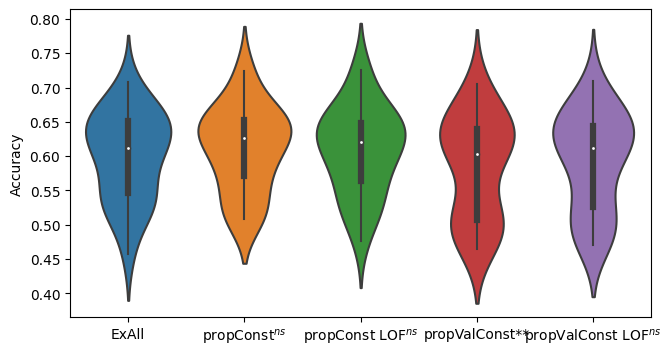

In [61]:
results_as_latex(df, aug_approaches=subpopulation_approaches, name="Subpopulation")
plot_violin(df,subpopulation_approaches, name="Subpopulation")
get_pivot_of_df(df,aug_approaches=subpopulation_approaches, values='acc')

In [88]:
get_pivot_of_df(df,aug_approaches=subpopulation_approaches, values='p_test_passed')

dataset                   amplus      dmg777k      dmgfull      mdgenre     
eval_method                  KNN  SVM     KNN  SVM     KNN  SVM     KNN  SVM
embedder augment                                                            
DistMult ExAll               1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         propConst           1.0  1.0     1.0  0.0     1.0  1.0     1.0  1.0
         propConst_LOF       1.0  1.0     0.0  0.0     1.0  1.0     1.0  0.0
         propValConst        1.0  0.0     1.0  1.0     1.0  1.0     0.0  0.0
         propValConst_LOF    1.0  1.0     1.0  0.0     1.0  1.0     0.0  0.0
RDF2Vec  ExAll               1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         propConst           1.0  1.0     0.0  1.0     1.0  0.0     0.0  0.0
         propConst_LOF       1.0  1.0     0.0  0.0     0.0  0.0     0.0  0.0
         propValConst        1.0  1.0     0.0  0.0     0.0  1.0     0.0  0.0
         propValConst_LOF    1.0  1.0     0.0  0.0     0.0  1.0     0.0  0.0
TransE   ExAll               1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         propConst           1.0  1.0     0.0  0.0     0.0  1.0     0.0  0.0
         propConst_LOF       1.0  1.0     1.0  0.0     1.0  0.0     0.0  0.0
         propValConst        1.0  0.0     0.0  1.0     1.0  0.0     0.0  0.0
         propValConst_LOF    0.0  0.0     1.0  0.0     1.0  0.0     0.0  0.0

In [84]:
results_as_latex(df, aug_approaches=subpopulation_approaches, name="Subpopulationf1", values='f1_macro')
get_pivot_of_df(df,aug_approaches=subpopulation_approaches, values='f1_macro')

dataset                   amplus        dmg777k        dmgfull        mdgenre  \
eval_method                  KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                                
DistMult ExAll             0.206  0.304   0.352  0.366   0.187  0.253   0.140   
         propConst         0.366  0.430   0.373  0.373   0.206  0.266   0.166   
         propConst_LOF     0.359  0.378   0.361  0.393   0.204  0.272   0.181   
         propValConst      0.244  0.324   0.364  0.440   0.160  0.235   0.124   
         propValConst_LOF  0.225  0.338   0.369  0.382   0.231  0.260   0.144   
RDF2Vec  ExAll             0.348  0.278   0.440  0.527   0.204  0.230   0.184   
         propConst         0.371  0.288   0.438  0.501   0.198  0.230   0.183   
         propConst_LOF     0.351  0.339   0.441  0.521   0.200  0.231   0.194   
         propValConst      0.252  0.222   0.436  0.483   0.211  0.274   0.187   
         propValConst_LOF  0.280  0.243   0.422  0.520   0.216  0.273   0.196   
TransE   ExAll             0.478  0.532   0.304  0.335   0.250  0.243   0.189   
         propConst         0.544  0.557   0.350  0.348   0.267  0.304   0.207   
         propConst_LOF     0.549  0.558   0.302  0.319   0.247  0.296   0.204   
         propValConst      0.492  0.524   0.309  0.324   0.264  0.297   0.183   
         propValConst_LOF  0.483  0.538   0.333  0.342   0.267  0.297   0.203   

dataset                           
eval_method                  SVM  
embedder augment                  
DistMult ExAll             0.163  
         propConst         0.187  
         propConst_LOF     0.183  
         propValConst      0.191  
         propValConst_LOF  0.151  
RDF2Vec  ExAll             0.200  
         propConst         0.201  
         propConst_LOF     0.206  
         propValConst      0.207  
         propValConst_LOF  0.206  
TransE   ExAll             0.165  
         propConst         0.171  
         propConst_LOF     0.176  
         propValConst      0.161  
         propValConst_LOF  0.176

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


result: propConst*** - 26.5 - 0.0006952045405260789
result: propConst LOF*** - 34.5 - 0.0004298686981201172
result: propValConst$^{ns}$ - 136.0 - 0.704756498336792
result: propValConst LOF* - 76.0 - 0.033985137939453125


{'propConst': 0.0006952045405260789,
 'propConst_LOF': 0.0004298686981201172,
 'propValConst': 0.704756498336792,
 'propValConst_LOF': 0.033985137939453125}

<Figure size 640x480 with 0 Axes>

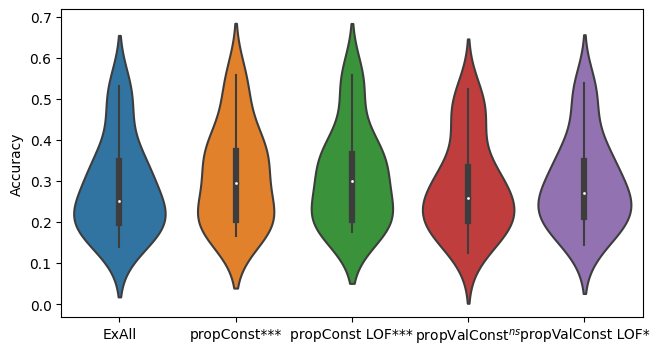

In [69]:
plot_violin(df,subpopulation_approaches, name="Subpopulation f1", measure="f1_macro")

In [82]:
wilcoxon_test(df,subpopulation_approaches,alternative='less',zero_method="wilcox",correction=False)

result: propConst - 92.0 - 0.08079628075470274
result: propConst LOF - 113.5 - 0.22804650894993778
result: propValConst - 243.5 - 0.9970511794090271
result: propValConst LOF - 188.0 - 0.8615922927856445


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [68]:
results_as_latex(df, aug_approaches=[*normal_bins,*pct_bins,*kga_approaches,*outlier_approaches,*subpopulation_approaches],  values='pct_acc_delta', columns='dataset', index='augment', name="Mean Percentual Performance Gains in Discretization")
get_pivot_of_df(df,aug_approaches=[*normal_bins,*pct_bins,*kga_approaches,*outlier_approaches,*subpopulation_approaches],  values='pct_acc_delta', columns='dataset', index='augment').round(3)

dataset,amplus,dmg777k,dmgfull,mdgenre
augment,,,,
100_bins,-3.460,-3.134,-1.547,-0.278
100_lof_bins,0.441,-1.530,0.061,0.424
100_overlapping,-4.666,-5.886,0.477,0.116
10_bins,-4.740,-0.728,-1.485,0.416
10_lof_bins,-2.043,-1.552,-0.187,0.973
10_overlapping,-5.049,-3.668,-1.078,0.459
10_pct_bins,NaN,-1.117,NaN,NaN
1_pct_bins,-7.843,0.201,-1.641,0.684
5_10_100_hierarchy,-5.845,-17.427,0.048,-0.587


# Class Extraction 

In [89]:
class_extraction= ["ExAll", "date_binning", "date_features", "LDA_topics", "VGG_classes"]

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


result: date binning$^{ns}$ - 12.5 - 0.12356498312705609
result: date features$^{ns}$ - 26.0 - 0.33935546875
result: LDA topics** - 50.5 - 0.0031430721282958984
result: VGG classes* - 76.5 - 0.033985137939453125


dataset                amplus        dmg777k        dmgfull        mdgenre  \
eval_method               KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                             
DistMult ExAll          0.458  0.512   0.548  0.542   0.619  0.658   0.605   
         LDA_topics     0.464  0.504   0.564  0.582   0.652  0.665   0.612   
         VGG_classes    0.485  0.528   0.549  0.552   0.553  0.642   0.606   
         date_binning   0.501  0.538     NaN    NaN     NaN    NaN   0.609   
         date_features  0.534  0.540     NaN    NaN     NaN    NaN   0.600   
RDF2Vec  ExAll          0.550  0.536   0.586  0.606   0.629  0.661   0.590   
         LDA_topics     0.606  0.610   0.620  0.636   0.631  0.663   0.591   
         VGG_classes    0.584  0.575   0.623  0.676   0.627  0.651   0.591   
         date_binning   0.554  0.523     NaN    NaN     NaN    NaN   0.591   
         date_features  0.488  0.493     NaN    NaN     NaN    NaN   0.591   
TransE   ExAll          0.682  0.708   0.506  0.528   0.649  0.662   0.634   
         LDA_topics     0.670  0.701   0.554  0.578   0.653  0.672   0.631   
         VGG_classes    0.723  0.735   0.560  0.588   0.656  0.671   0.632   
         date_binning   0.683  0.719     NaN    NaN     NaN    NaN   0.634   
         date_features  0.678  0.701     NaN    NaN     NaN    NaN   0.632   

dataset                        
eval_method               SVM  
embedder augment               
DistMult ExAll          0.622  
         LDA_topics     0.623  
         VGG_classes    0.621  
         date_binning   0.626  
         date_features  0.621  
RDF2Vec  ExAll          0.662  
         LDA_topics     0.660  
         VGG_classes    0.660  
         date_binning   0.662  
         date_features  0.661  
TransE   ExAll          0.646  
         LDA_topics     0.648  
         VGG_classes    0.644  
         date_binning   0.642  
         date_features  0.647

<Figure size 640x480 with 0 Axes>

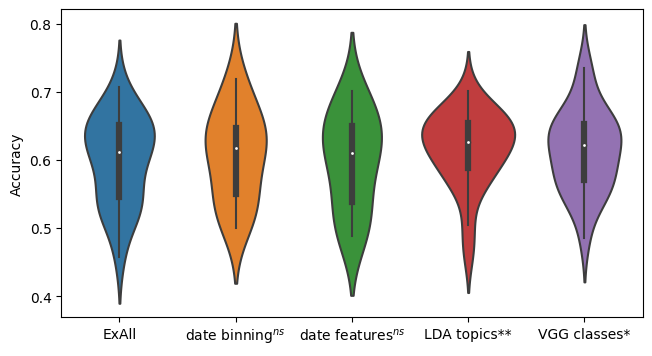

In [90]:
results_as_latex(df, aug_approaches=class_extraction, name="Extract Features")
plot_violin(df,class_extraction, name="Extract Features")
get_pivot_of_df(df,aug_approaches=class_extraction, values='acc')

In [92]:
get_pivot_of_df(df,aug_approaches=class_extraction, values='p_test_passed')

dataset                amplus      dmg777k      dmgfull      mdgenre     
eval_method               KNN  SVM     KNN  SVM     KNN  SVM     KNN  SVM
embedder augment                                                         
DistMult ExAll            1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         LDA_topics       0.0  1.0     0.0  1.0     1.0  1.0     0.0  0.0
         VGG_classes      1.0  1.0     0.0  0.0     1.0  1.0     0.0  0.0
         date_binning     1.0  1.0     NaN  NaN     NaN  NaN     0.0  0.0
         date_features    1.0  1.0     NaN  NaN     NaN  NaN     0.0  0.0
RDF2Vec  ExAll            1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         LDA_topics       1.0  1.0     1.0  1.0     0.0  0.0     0.0  0.0
         VGG_classes      1.0  1.0     1.0  1.0     0.0  1.0     0.0  0.0
         date_binning     0.0  1.0     NaN  NaN     NaN  NaN     0.0  0.0
         date_features    1.0  1.0     NaN  NaN     NaN  NaN     0.0  0.0
TransE   ExAll            1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         LDA_topics       1.0  1.0     1.0  1.0     0.0  1.0     0.0  0.0
         VGG_classes      1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0
         date_binning     0.0  1.0     NaN  NaN     NaN  NaN     0.0  0.0
         date_features    0.0  1.0     NaN  NaN     NaN  NaN     0.0  0.0

result: date binning* - 7.5 - 0.023239746607663567
result: date features$^{ns}$ - 34.0 - 0.7333984375
result: LDA topics*** - 35.0 - 0.0004944801330566406
result: VGG classes** - 35.5 - 0.0018226021263969816


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


{'date_binning': 0.023239746607663567,
 'date_features': 0.7333984375,
 'LDA_topics': 0.0004944801330566406,
 'VGG_classes': 0.0018226021263969816}

<Figure size 640x480 with 0 Axes>

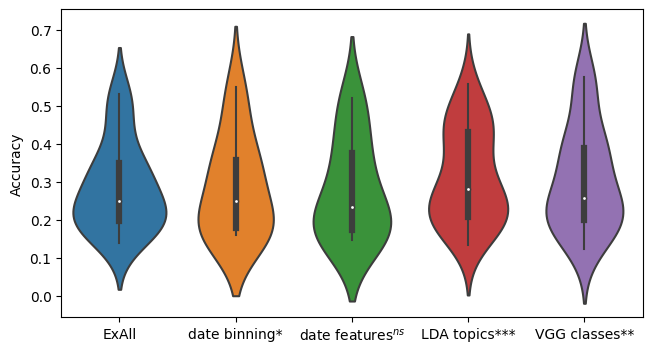

In [91]:
plot_violin(df,class_extraction, name="Extract Features",measure="f1_macro")

# MKDA  

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


result: ExImages** - 206.5 - 0.0049206046534729314
result: propConst LOF$^{ns}$ - 162.5 - 0.23266895515884162
result: VGG classes* - 223.5 - 0.018324613571166992
result: LDA topics** - 249.5 - 0.0017521381378173828
result: MKGA*** - 253.5 - 0.00023427148893674567


dataset                amplus        dmg777k        dmgfull        mdgenre  \
eval_method               KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                             
DistMult ExAll          0.458  0.512   0.548  0.542   0.619  0.658   0.605   
         ExImages       0.520  0.570   0.585  0.595   0.562  0.584   0.591   
         LDA_topics     0.464  0.504   0.564  0.582   0.652  0.665   0.612   
         MKGA           0.542  0.590   0.579  0.583   0.595  0.643   0.612   
         VGG_classes    0.485  0.528   0.549  0.552   0.553  0.642   0.606   
         propConst_LOF  0.564  0.608   0.528  0.523   0.634  0.673   0.616   
RDF2Vec  ExAll          0.550  0.536   0.586  0.606   0.629  0.661   0.590   
         ExImages       0.609  0.611   0.626  0.627   0.637  0.687   0.580   
         LDA_topics     0.606  0.610   0.620  0.636   0.631  0.663   0.591   
         MKGA           0.688  0.691   0.664  0.665   0.650  0.715   0.586   
         VGG_classes    0.584  0.575   0.623  0.676   0.627  0.651   0.591   
         propConst_LOF  0.536  0.564   0.594  0.594   0.626  0.660   0.584   
TransE   ExAll          0.682  0.708   0.506  0.528   0.649  0.662   0.634   
         ExImages       0.731  0.763   0.607  0.603   0.667  0.690   0.634   
         LDA_topics     0.670  0.701   0.554  0.578   0.653  0.672   0.631   
         MKGA           0.760  0.779   0.627  0.643   0.709  0.726   0.635   
         VGG_classes    0.723  0.735   0.560  0.588   0.656  0.671   0.632   
         propConst_LOF  0.716  0.726   0.476  0.512   0.643  0.664   0.638   

dataset                        
eval_method               SVM  
embedder augment               
DistMult ExAll          0.622  
         ExImages       0.617  
         LDA_topics     0.623  
         MKGA           0.620  
         VGG_classes    0.621  
         propConst_LOF  0.632  
RDF2Vec  ExAll          0.662  
         ExImages       0.662  
         LDA_topics     0.660  
         MKGA           0.661  
         VGG_classes    0.660  
         propConst_LOF  0.662  
TransE   ExAll          0.646  
         ExImages       0.638  
         LDA_topics     0.648  
         MKGA           0.646  
         VGG_classes    0.644  
         propConst_LOF  0.644

<Figure size 640x480 with 0 Axes>

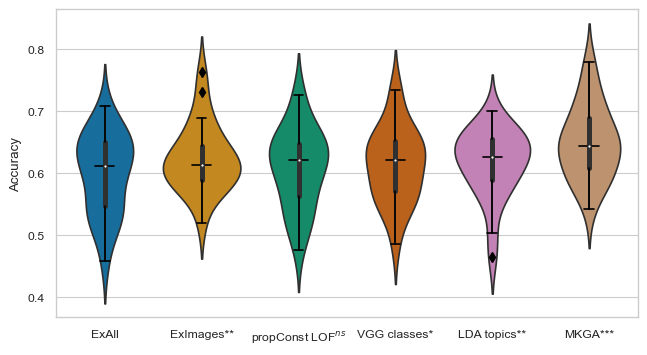

In [126]:
mkda_relevant = ['ExAll', "ExImages", "propConst_LOF", 'VGG_classes',"LDA_topics",'MKGA']
results_as_latex(df, aug_approaches=mkda_relevant, name="MKDA Results")
plot_violin(df,mkda_relevant, name="MKDA Results")
get_pivot_of_df(df,aug_approaches=mkda_relevant, values='acc')

In [142]:
get_pivot_of_df(df,aug_approaches=mkda_relevant, values='acc')

dataset                amplus        dmg777k        dmgfull        mdgenre  \
eval_method               KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                             
DistMult ExAll          0.458  0.512   0.548  0.542   0.619  0.658   0.605   
         ExImages       0.520  0.570   0.585  0.595   0.562  0.584   0.591   
         LDA_topics     0.464  0.504   0.564  0.582   0.652  0.665   0.612   
         MKGA             NaN    NaN   0.579  0.583     NaN    NaN     NaN   
         VGG_classes    0.485  0.528   0.549  0.552   0.553  0.642   0.606   
         propConst_LOF  0.564  0.608   0.528  0.523   0.634  0.673   0.616   
RDF2Vec  ExAll          0.550  0.536   0.586  0.606   0.629  0.661   0.590   
         ExImages       0.609  0.611   0.626  0.627   0.637  0.687   0.580   
         LDA_topics     0.606  0.610   0.620  0.636   0.631  0.663   0.591   
         MKGA             NaN    NaN   0.664  0.665     NaN    NaN     NaN   
         VGG_classes    0.584  0.575   0.623  0.676   0.627  0.651   0.591   
         propConst_LOF  0.536  0.564   0.594  0.594   0.626  0.660   0.584   
TransE   ExAll          0.682  0.708   0.506  0.528   0.649  0.662   0.634   
         ExImages       0.731  0.763   0.607  0.603   0.667  0.690   0.634   
         LDA_topics     0.670  0.701   0.554  0.578   0.653  0.672   0.631   
         MKGA           0.760  0.779   0.627  0.643     NaN    NaN     NaN   
         VGG_classes    0.723  0.735   0.560  0.588   0.656  0.671   0.632   
         propConst_LOF  0.716  0.726   0.476  0.512   0.643  0.664   0.638   

dataset                        
eval_method               SVM  
embedder augment               
DistMult ExAll          0.622  
         ExImages       0.617  
         LDA_topics     0.623  
         MKGA             NaN  
         VGG_classes    0.621  
         propConst_LOF  0.632  
RDF2Vec  ExAll          0.662  
         ExImages       0.662  
         LDA_topics     0.660  
         MKGA             NaN  
         VGG_classes    0.660  
         propConst_LOF  0.662  
TransE   ExAll          0.646  
         ExImages       0.638  
         LDA_topics     0.648  
         MKGA             NaN  
         VGG_classes    0.644  
         propConst_LOF  0.644

## H1

In [446]:
results['dmg777k+InAll$TransE$KNN']

{'a': 809,
 'b': 395,
 'c': 203,
 'd': 594,
 'base_pred_acc': 0.506,
 'statistic': 61.00501672240803,
 'pvalue': 5.692955409037683e-15}

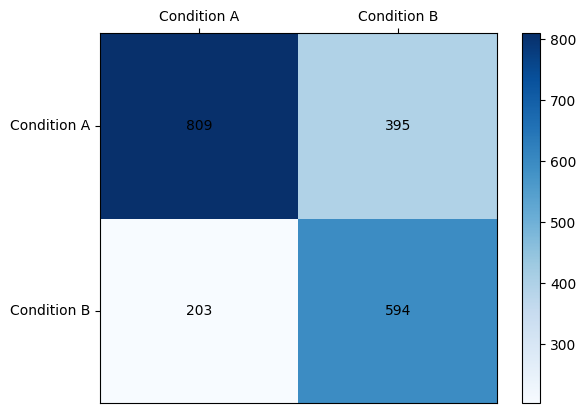

In [492]:
import matplotlib.pyplot as plt
import numpy as np

# Define the 2x2 matrix
best_case = results['dmg777k+InAll$TransE$KNN']
matrix = np.array([[best_case['a'],best_case['b']],[best_case['c'],best_case['d']]])

# Define the labels for the rows and columns
row_labels = ['Condition A', 'Condition B']
col_labels = ['Condition A', 'Condition B']

# Create a figure and an axis
fig, ax = plt.subplots()

heatmap = ax.pcolor(matrix[::-1], cmap='Blues')  # Reverse the matrix to have "true true" at the top left corner
# Add colorbar
# cbar = plt.colorbar(heatmap)
# Add labels to each cell
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j + 0.5, i + 0.5, matrix[::-1][i, j], ha='center', va='center')

# Set the ticks in the middle of the cells
ax.set_xticks(np.arange(matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0]) + 0.5, minor=False)

# Add the labels on top
ax.set_xticklabels(col_labels, ha='center')  # Align the labels to the left
ax.set_yticklabels(row_labels[::-1], va='center')  # Reverse and align the labels to the bottom
# ax.invert_yaxis()
ax.xaxis.tick_top()
# Add colorbar
cbar = plt.colorbar(heatmap)



# Show the plot
plt.show()

In [556]:
print(mcnemar(matrix,correction=True))

pvalue      3.315594629242411e-15
statistic   203.0


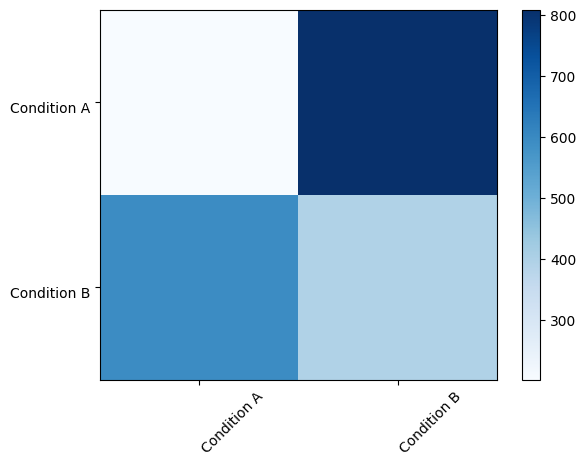

In [478]:
# matrix = np.array([[d, b], [c, a]])  # Swap a and d to place "true true" at the top left corner
best_case = results['dmg777k+InAll$TransE$KNN']
matrix = np.array([[best_case['d'],best_case['b']],[best_case['c'],best_case['a']]])

# Define the labels for the rows and columns
row_labels = ['Condition B', 'Condition A']  # Reverse the row labels order
col_labels = ['Condition A', 'Condition B']

# Create a figure and an axis
fig, ax = plt.subplots()

# Create the heatmap
heatmap = ax.pcolor(matrix, cmap='Blues')

# Set the ticks in the middle of the cells
ax.set_xticks(np.arange(matrix.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0]) + 0.5, minor=False)

# Add the labels on top
ax.set_xticklabels(col_labels, rotation=45, ha='left')  # Align the labels to the left
ax.set_yticklabels(row_labels, va='top')  # Align the labels to the top

# Add colorbar
cbar = plt.colorbar(heatmap)
for  y in range(2):
    for x in range(2):
        # label = data[y_index, x_index]
        # text_x = x + jump_x
        # text_y = y + jump_y
        ax.text(x,y, mcnemar_matrix[x,1-y], color='black', ha='center', va='center')

# Show the plot
plt.show()

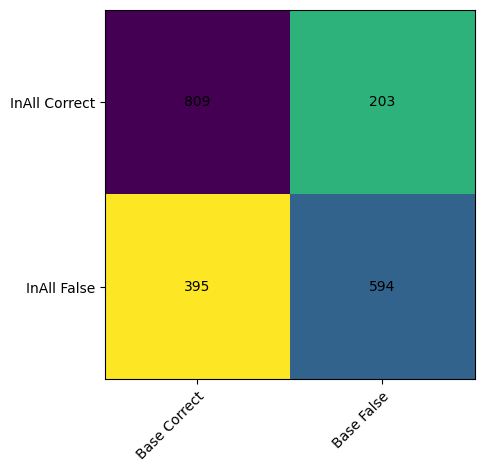

In [474]:
import matplotlib.pyplot as plt
best_case = results['dmg777k+InAll$TransE$KNN']
mcnemar_matrix = np.array([[best_case['a'],best_case['b']],[best_case['c'],best_case['d']]])
fig, ax = plt.subplots()
im = ax.imshow(mcnemar_matrix, origin='lower', interpolation='None', cmap='viridis')
ax.set_xticks(np.arange(2), labels=['Base Correct', 'Base False'])
ax.xaxis.set_label_position('top') 
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_yticks(np.arange(2), labels=['InAll Correct','InAll False'][::-1])
for  y in range(2):
    for x in range(2):
        # label = data[y_index, x_index]
        # text_x = x + jump_x
        # text_y = y + jump_y
        ax.text(x,y, mcnemar_matrix[x,1-y], color='black', ha='center', va='center')

# size = 2
# data = np.arange(size * size).reshape((size, size))
# x_start = 1.0
# x_end = 2.0
# y_start = 1.0
# y_end = 2.0

# jump_x = (x_end - x_start) / (2.0 * size)
# jump_y = (y_end - y_start) / (2.0 * size)
# x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
# y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

# for y_index, y in enumerate(y_positions):
#     for x_index, x in enumerate(x_positions):
#         label = data[y_index, x_index]
#         text_x = x + jump_x
#         text_y = y + jump_y
#         ax.text(text_x, text_y, label, color='black', ha='center', va='center')

# for  y in range(2):
#     for x in range(2):
#         # label = data[y_index, x_index]
#         # text_x = x + jump_x
#         # text_y = y + jump_y
#         ax.text(1-x,1-y, f'{x}-{y}', color='black', ha='center', va='center')


# for (j,i),label in np.ndenumerate(mcnemar_matrix):
#     ax1.text(i,j,label,ha='center',va='center')
#     ax2.text(i,j,label,ha='center',va='center')
plt.colorbar()
plt.show()



In [460]:
mcnemar_matrix

array([[809, 395],
       [203, 594]])

# bins

In [503]:
df

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,pct_acc_delta,p_test_passed,i
0,0.458,0.240,0.458,1.0,amplus,KNN,100_bins,DistMult,6432,2720,2722,8126,0.458,0.000184,9.891845e-01,0.000,0.000000,False,0
1,0.492,0.315,0.492,1.0,amplus,SVM,100_bins,DistMult,7335,2503,2898,7264,0.512,28.742085,8.268718e-08,-0.020,-3.906250,True,1
2,0.498,0.273,0.498,1.0,amplus,KNN,100_bins,RDF2Vec,8935,1016,2074,7975,0.550,361.569256,1.281991e-80,-0.052,-9.454545,True,2
3,0.501,0.229,0.501,1.0,amplus,SVM,100_bins,RDF2Vec,9316,698,1412,8574,0.536,240.933175,2.461689e-54,-0.035,-6.529851,True,3
4,0.678,0.478,0.678,1.0,amplus,KNN,100_bins,TransE,12236,1330,1400,5034,0.682,1.743956,1.866383e-01,-0.004,-0.586510,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.620,0.151,0.620,1.0,mdgenre,SVM,propValConst_LOF,DistMult,1751,110,114,1025,0.622,0.040179,8.411318e-01,-0.002,-0.321543,False,743
744,0.588,0.196,0.588,1.0,mdgenre,KNN,propValConst_LOF,RDF2Vec,1635,129,135,1101,0.590,0.094697,7.582888e-01,-0.002,-0.338983,False,744
745,0.661,0.206,0.661,1.0,mdgenre,SVM,propValConst_LOF,RDF2Vec,1945,37,41,977,0.662,0.115385,7.340952e-01,-0.001,-0.151057,False,745
746,0.643,0.203,0.643,1.0,mdgenre,KNN,propValConst_LOF,TransE,1818,112,84,986,0.634,3.719388,5.378409e-02,0.009,1.419558,False,746


In [501]:
df['i']= df.index

In [505]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [514]:
pt = df[df['augment'].isin(bas)].pivot_table(values='acc',columns=['augment'], index=['dataset','embedder','eval_method']).reset_index()

In [513]:
pt.reset_index()['ExAll'].values

array([0.458, 0.512, 0.55 , 0.536, 0.682, 0.708, 0.548, 0.542, 0.586,
       0.606, 0.506, 0.528, 0.619, 0.658, 0.629, 0.661, 0.649, 0.662,
       0.605, 0.622, 0.59 , 0.662, 0.634, 0.646])

In [560]:
from scipy.stats import wilcoxon
pt = df[df['augment'].isin(aug_approaches)].pivot_table(values='f1_macro',columns=['augment'], index=['dataset','embedder','eval_method']).reset_index()

# Accuracies of the two preprocessing methods on multiple datasets
method1_scores = pt['ExAll'].values  # Replace with actual accuracies for method 1
method2_scores = pt['OneEntPerRel'].values  # Replace with actual accuracies for method 2

# Perform the Wilcoxon signed-rank test
statistic, p_value = wilcoxon(pt['ExAll'].values, pt['OneEntPerRel'].values)

# Print the test statistic and p-value
print("Test Statistic:", statistic)
print("P-value:", p_value)

Test Statistic: 64.0
P-value: 0.012604832649230957


In [519]:
%pip install seaborn 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


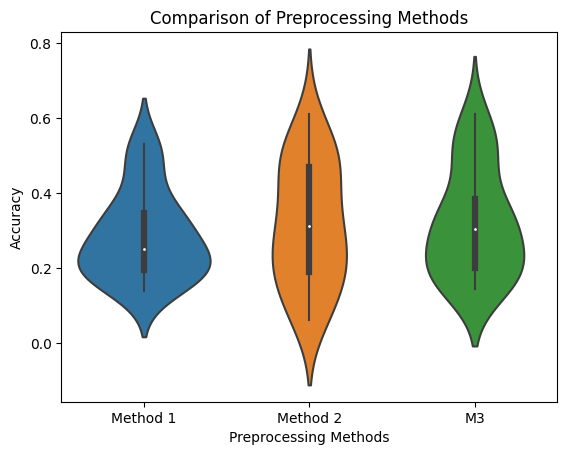

In [534]:
import seaborn as sns

# Accuracies of the two preprocessing methods on multiple datasets
method1_scores = list(pt['ExAll'].values)  # Replace with actual accuracies for method 1
method2_scores = list(pt['InAll'].values) 
method3_scores = list(pt['OneEntPerRel'].values) # Replace with actual accuracies for method 2

# Create a list of data for the swarm plot
data = [method1_scores, method2_scores, method3_scores]

# Create a list of labels for the x-axis
labels = ['Method 1', 'Method 2', 'M3']

# Plotting
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1,2], labels=labels)
plt.title('Comparison of Preprocessing Methods')
plt.xlabel('Preprocessing Methods')
plt.ylabel('Accuracy')

# Save or show the plot
plt.savefig('wilcoxon_violinplot.png')
plt.show()

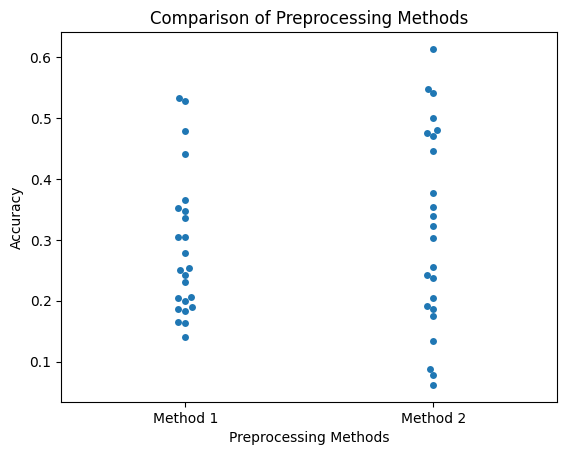

In [526]:
import seaborn as sns

# Accuracies of the two preprocessing methods on multiple datasets
method1_scores = list(pt['ExAll'].values)  # Replace with actual accuracies for method 1
method2_scores = list(pt['InAll'].values)  # Replace with actual accuracies for method 2

# Create a list of data for the swarm plot
data = method1_scores + method2_scores

# Create a list of labels for the x-axis
labels = ['Method 1'] * len(method1_scores) + ['Method 2'] * len(method2_scores)

# Plotting
sns.swarmplot(x=labels, y=data)
plt.title('Comparison of Preprocessing Methods')
plt.xlabel('Preprocessing Methods')
plt.ylabel('Accuracy')

# Save or show the plot
plt.savefig('wilcoxon_swarmplot.png')
plt.show()

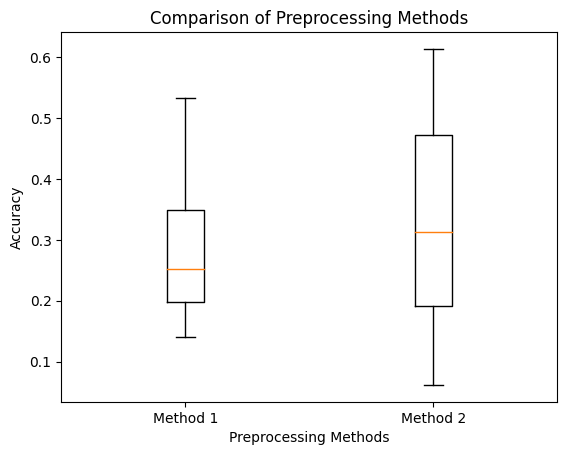

In [518]:
# Create a list of data for the box plot
data = [pt.reset_index()['ExAll'].values, pt.reset_index()['InAll'].values]

# Create a list of labels for the x-axis
labels = ['Method 1', 'Method 2']

# Plotting
plt.boxplot(data, labels=labels)

# Add title and axis labels
plt.title('Comparison of Preprocessing Methods')
plt.xlabel('Preprocessing Methods')
plt.ylabel('Accuracy')

# Add significance stars or other symbols
# You can use the p-value obtained from the Wilcoxon test to determine significance levels

# Save or show the plot
plt.savefig('wilcoxon_boxplot.png')
plt.show()

In [504]:
df[df['augment'].isin(['InAll','ExAll'])].pivot_table(values='acc',columns=['augment'], index=['dataset','embedder','eval_method'])

augment                       ExAll  InAll
dataset embedder eval_method              
amplus  DistMult KNN          0.458  0.477
                 SVM          0.512  0.546
        RDF2Vec  KNN          0.550  0.616
                 SVM          0.536  0.616
        TransE   KNN          0.682  0.727
                 SVM          0.708  0.761
dmg777k DistMult KNN          0.548  0.593
                 SVM          0.542  0.611
        RDF2Vec  KNN          0.586  0.626
                 SVM          0.606  0.628
        TransE   KNN          0.506  0.602
                 SVM          0.528  0.611
dmgfull DistMult KNN          0.619  0.560
                 SVM          0.658  0.576
        RDF2Vec  KNN          0.629  0.635
                 SVM          0.661  0.685
        TransE   KNN          0.649  0.665
                 SVM          0.662  0.688
mdgenre DistMult KNN          0.605  0.575
                 SVM          0.622  0.610
        RDF2Vec  KNN          0.590  0.583
                 SVM          0.662  0.658
        TransE   KNN          0.634  0.639
                 SVM          0.646  0.649

In [362]:
df['augment'].unique()

array(['100_bins', '100_lof_bins', '100_overlapping', '10_bins',
       '10_lof_bins', '10_overlapping', '10_pct_bins', '1_pct_bins',
       '5_10_100_hierarchy', '5_bins', '5_lof_bins', '5_pct_bins',
       '5lvl_binary_hierarchy', 'ExAll', 'ExDates', 'ExImages',
       'ExNumbers', 'ExText', 'InAll', 'InDates', 'InImages', 'InNumbers',
       'InText', 'LDA_topics', 'OneEntPerRel', 'VGG_classes',
       'date_binning', 'date_features', 'propConst', 'propConst_LOF',
       'propValConst', 'propValConst_LOF', 'testbins'], dtype=object)

In [392]:
base_bins = ['ExAll','100_bins', '10_bins',
       '10_pct_bins', '1_pct_bins',
        '5_bins', '5_pct_bins',
       ]

In [394]:

get_pivot_of_df(df,aug_approaches=base_bins, values='pct_acc_delta')

dataset                  amplus              dmg777k              dmgfull  \
eval_method                 KNN        SVM       KNN        SVM       KNN   
embedder augment                                                            
DistMult 100_bins      0.000000  -3.906250 -1.824818   3.505535 -7.915994   
         10_bins      -1.528384  -2.929688 -3.467153   0.184502 -4.200323   
         10_pct_bins -14.628821 -13.281250 -2.737226   2.952030 -9.854604   
         1_pct_bins  -14.628821 -13.281250 -2.737226   2.952030 -9.854604   
         5_bins       -3.275109  -8.203125 -1.094891   4.981550 -4.038772   
         5_pct_bins  -14.628821 -13.281250 -2.737226   2.952030 -9.854604   
         ExAll         0.000000   0.000000  0.000000   0.000000  0.000000   
RDF2Vec  100_bins     -9.454545  -6.529851  2.901024  -4.455446 -0.317965   
         10_bins     -15.454545  -7.089552  3.242321  -1.815182  0.158983   
         10_pct_bins -10.363636  -6.343284  1.706485  -0.165017 -0.158983   
         1_pct_bins  -10.363636  -6.343284  1.706485  -0.165017 -0.158983   
         5_bins      -15.272727  -6.156716  1.535836   1.155116 -0.317965   
         5_pct_bins  -10.363636  -6.343284  1.706485  -0.165017 -0.158983   
         ExAll         0.000000   0.000000  0.000000   0.000000  0.000000   
TransE   100_bins     -0.586510  -0.282486 -8.893281 -10.037879  1.078582   
         10_bins      -0.733138  -0.706215 -1.185771  -1.325758 -0.924499   
         10_pct_bins  -1.026393  -1.412429  0.395257  -0.946970  1.386749   
         1_pct_bins   -1.026393  -1.412429  0.395257  -0.946970  1.386749   
         5_bins       -0.293255  -0.564972 -4.545455  -9.469697 -0.770416   
         5_pct_bins   -1.026393  -1.412429  0.395257  -0.946970  1.386749   
         ExAll         0.000000   0.000000  0.000000   0.000000  0.000000   

dataset                          mdgenre            
eval_method                SVM       KNN       SVM  
embedder augment                                    
DistMult 100_bins    -1.215805 -0.661157  0.643087  
         10_bins     -1.975684  1.652893  1.125402  
         10_pct_bins -1.063830  1.322314  1.607717  
         1_pct_bins  -1.063830  1.322314  1.607717  
         5_bins      -0.759878  1.983471  1.768489  
         5_pct_bins  -1.063830  1.322314  1.607717  
         ExAll        0.000000  0.000000  0.000000  
RDF2Vec  100_bins    -1.512859 -1.186441 -0.151057  
         10_bins     -2.723147 -1.694915 -0.151057  
         10_pct_bins -1.210287 -0.847458  0.453172  
         1_pct_bins  -1.210287 -0.847458  0.453172  
         5_bins      -1.210287 -0.169492 -0.302115  
         5_pct_bins  -1.210287 -0.847458  0.453172  
         ExAll        0.000000  0.000000  0.000000  
TransE   100_bins     0.604230  0.000000 -0.309598  
         10_bins      0.755287  0.788644  0.773994  
         10_pct_bins  1.057402  1.104101  0.464396  
         1_pct_bins   1.057402  1.104101  0.464396  
         5_bins       0.453172  0.315457 -0.464396  
         5_pct_bins   1.057402  1.104101  0.464396  
         ExAll        0.000000  0.000000  0.000000

In [271]:
i = 0
latex_string = ""
for embedder in df['embedder'].unique():
    embedder_pt = df[df['embedder'] == embedder].pivot_table(values='acc',
                                                             index=['augment'],
                                                             columns=['dataset', 'eval_method']).query("augment ==  @baselines")
    seperator = ""
    seperator = f"\\midrule \n \\multicolumn{{9}}{{c}}{{{embedder}}} \\\\ \n \\midrule \n"

    latex_substring = embedder_pt.style.format({
   ("Numeric", "Integers"): '\${}',
   ("Numeric", "Floats"): '{:.3f}',
   ("Non-Numeric", "Strings"): str.upper
}).highlight_max(axis=None,
                           props='bfseries: ;').to_latex(
        column_format="llcccccccc", multicolumn_format="c")
    header = latex_substring.split('\\midrule')[0]
    latex_substring = latex_substring.split('\\midrule')[1]
    latex_substring = seperator + latex_substring

    if i == 0:
        crules = " \\cmidrule(lr){2-3}\\cmidrule(lr){4-5}\\cmidrule(lr){6-7}\\cmidrule(lr){8-9}\n"

        header = re.sub(r'eval\\_method', '', header)
        header = re.sub(r'dataset', '', header)
        header = re.sub(r'augment.*', '', header)
        print(len(header))
        hs = header.split('\n')
        header = ""
        for j in range(len(hs)):
            if j == 3:
                header += crules
            header += hs[j]
            header += "\n"
        header += "\\midrule"

        # for line in header.split('\n'):

        latex_substring = header + latex_substring
        # header = latex_substring.split('\\midrule')[0]
        # latex_substring = latex_substring.split('\\midrule')[1]

    else:
        pass
        # latex_substring = embedder_pt.to_latex(column_format= "lcccccccc" ,multicolumn_format="c", header = "")
        # latex_substring = re.sub(r'.*\n.*toprule','', latex_substring )
        # latex_substring = seperator + latex_substring

    if i < len(df['embedder'].unique()) - 1:
        latex_substring = re.sub(r'.*\n.*end.*', "", latex_substring)
    i += 1
    latex_string += latex_substring
print(latex_string)


with open('a.txt', "w") as f:
    f.write(latex_string)


TypeError: to_latex() got an unexpected keyword argument 'multicolumn_format'

In [265]:
df.pivot_table(values='acc', 
               index = ['embedder', 'augment'], 
               columns= ['dataset','eval_method']).query("augment ==  @baselines")

dataset               amplus        dmg777k        dmgfull        mdgenre  \
eval_method              KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                            
DistMult ExAll         0.458  0.512   0.548  0.542   0.619  0.658   0.605   
         InAll         0.477  0.546   0.593  0.611   0.560  0.576   0.575   
         OneEntPerRel  0.511  0.549   0.517  0.501   0.613  0.649   0.599   
RDF2Vec  ExAll         0.550  0.536   0.586  0.606   0.629  0.661   0.590   
         InAll         0.616  0.616   0.626  0.628   0.635  0.685   0.583   
         OneEntPerRel  0.588  0.612   0.630  0.609   0.631  0.679   0.565   
TransE   ExAll         0.682  0.708   0.506  0.528   0.649  0.662   0.634   
         InAll         0.727  0.761   0.602  0.611   0.665  0.688   0.639   
         OneEntPerRel  0.737  0.761   0.610  0.621   0.657  0.673   0.641   

dataset                       
eval_method              SVM  
embedder augment              
DistMult ExAll         0.622  
         InAll         0.610  
         OneEntPerRel  0.617  
RDF2Vec  ExAll         0.662  
         InAll         0.658  
         OneEntPerRel  0.657  
TransE   ExAll         0.646  
         InAll         0.649  
         OneEntPerRel  0.647

In [266]:
relevant_colums = ['acc','f1_macro','dataset','eval_method','augment','embedder','acc_delta','pvalue','p_test_passed']

In [138]:
displayed_colums = ['acc','dataset','eval_method','augment','embedder']

In [116]:
baselines = ["ExAll", "InAll", "OneEntPerRel"]

In [ ]:
df[(df['augment'].isin(baselines))&(df['dataset']=='amplus')&(df['eval_method']=="SVM")][relevant_colums].sort_values('embedder')

In [145]:
df['dataset'].unique()

array(['amplus', 'dmg777k', 'dmgfull', 'mdgenre'], dtype=object)

In [178]:
columns = [[],[]]
for dataset in df['dataset'].unique():
    for eval_method in df['eval_method'].unique():
        columns[0].append(dataset)
        columns[1].append(eval_method)


In [203]:
df

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,p_test_passed
0,0.458,0.240,0.458,1.0,amplus,KNN,100_bins,DistMult,6432,2720,2722,8126,0.458,0.000184,9.891845e-01,0.000,False
1,0.492,0.315,0.492,1.0,amplus,SVM,100_bins,DistMult,7335,2503,2898,7264,0.512,28.742085,8.268718e-08,-0.020,True
2,0.498,0.273,0.498,1.0,amplus,KNN,100_bins,RDF2Vec,8935,1016,2074,7975,0.550,361.569256,1.281991e-80,-0.052,True
3,0.501,0.229,0.501,1.0,amplus,SVM,100_bins,RDF2Vec,9316,698,1412,8574,0.536,240.933175,2.461689e-54,-0.035,True
4,0.678,0.478,0.678,1.0,amplus,KNN,100_bins,TransE,12236,1330,1400,5034,0.682,1.743956,1.866383e-01,-0.004,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.620,0.151,0.620,1.0,mdgenre,SVM,propValConst_LOF,DistMult,1751,110,114,1025,0.622,0.040179,8.411318e-01,-0.002,False
744,0.588,0.196,0.588,1.0,mdgenre,KNN,propValConst_LOF,RDF2Vec,1635,129,135,1101,0.590,0.094697,7.582888e-01,-0.002,False
745,0.661,0.206,0.661,1.0,mdgenre,SVM,propValConst_LOF,RDF2Vec,1945,37,41,977,0.662,0.115385,7.340952e-01,-0.001,False
746,0.643,0.203,0.643,1.0,mdgenre,KNN,propValConst_LOF,TransE,1818,112,84,986,0.634,3.719388,5.378409e-02,0.009,False


In [205]:
dfc = df.copy()

In [188]:
dfc = dfc[['acc','dataset','eval_method', 'embedder', 'augment']]

In [193]:
dfc_pivot = dfc.pivot_table(values='acc', index = ['embedder', 'augment'], columns= ['dataset','eval_method']).query("augment ==  @baselines")

In [206]:
dfc.pivot_table(values='p_test_passed', index = ['embedder', 'augment'], columns= ['dataset','eval_method']).query("augment ==  @baselines")

dataset               amplus      dmg777k      dmgfull      mdgenre     
eval_method              KNN  SVM     KNN  SVM     KNN  SVM     KNN  SVM
embedder augment                                                        
DistMult ExAll           1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         InAll           1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         OneEntPerRel    1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0
RDF2Vec  ExAll           1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         InAll           1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0
         OneEntPerRel    1.0  1.0     1.0  0.0     0.0  1.0     1.0  0.0
TransE   ExAll           1.0  1.0     1.0  1.0     1.0  1.0     1.0  1.0
         InAll           1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0
         OneEntPerRel    1.0  1.0     1.0  1.0     1.0  1.0     0.0  0.0

In [202]:
dfc_pivot.query("augment ==  @baselines")

dataset               amplus        dmg777k        dmgfull        mdgenre  \
eval_method              KNN    SVM     KNN    SVM     KNN    SVM     KNN   
embedder augment                                                            
DistMult ExAll         0.458  0.512   0.548  0.542   0.619  0.658   0.605   
         InAll         0.477  0.546   0.593  0.611   0.560  0.576   0.575   
         OneEntPerRel  0.511  0.549   0.517  0.501   0.613  0.649   0.599   
RDF2Vec  ExAll         0.550  0.536   0.586  0.606   0.629  0.661   0.590   
         InAll         0.616  0.616   0.626  0.628   0.635  0.685   0.583   
         OneEntPerRel  0.588  0.612   0.630  0.609   0.631  0.679   0.565   
TransE   ExAll         0.682  0.708   0.506  0.528   0.649  0.662   0.634   
         InAll         0.727  0.761   0.602  0.611   0.665  0.688   0.639   
         OneEntPerRel  0.737  0.761   0.610  0.621   0.657  0.673   0.641   

dataset                       
eval_method              SVM  
embedder augment              
DistMult ExAll         0.622  
         InAll         0.610  
         OneEntPerRel  0.617  
RDF2Vec  ExAll         0.662  
         InAll         0.658  
         OneEntPerRel  0.657  
TransE   ExAll         0.646  
         InAll         0.649  
         OneEntPerRel  0.647

In [201]:
ltx = dfc_pivot.query("augment ==  @baselines")

In [200]:
ltx = dfc_pivot.query("augment ==  @baselines").round(2).to_latex()
with open('a.txt',"w") as f:
    f.write(ltx)

C:\Users\Noctris\AppData\Local\Temp\ipykernel_44908\2193323556.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ltx = dfc_pivot.query("augment ==  @baselines").round(2).to_latex()


In [179]:
index = pd.MultiIndex.from_frame(df[['embedder','augment']], names=('embedder', 'augment'))
columns = pd.MultiIndex.from_arrays(columns, names=('dataset', 'eval_method'))

In [ ]:
dfc.pivot_table(values='acc', index=dfc.index, columns= ['dataset','eval_method'])

In [180]:
columns

MultiIndex([( 'amplus', 'KNN'),
            ( 'amplus', 'SVM'),
            ('dmg777k', 'KNN'),
            ('dmg777k', 'SVM'),
            ('dmgfull', 'KNN'),
            ('dmgfull', 'SVM'),
            ('mdgenre', 'KNN'),
            ('mdgenre', 'SVM')],
           names=['dataset', 'eval_method'])

In [185]:
dfc.pivot_table(values='acc', index=dfc.index, columns= ['dataset','eval_method'])

dataset                     amplus        dmg777k        dmgfull         \
eval_method                    KNN    SVM     KNN    SVM     KNN    SVM   
(DistMult, 100_bins)         0.458  0.492   0.538  0.561   0.570  0.650   
(DistMult, 100_lof_bins)     0.476  0.507   0.512  0.537   0.627  0.664   
(DistMult, 100_overlapping)  0.457  0.482   0.505  0.543   0.633  0.655   
(DistMult, 10_bins)          0.451  0.497   0.529  0.543   0.593  0.645   
(DistMult, 10_lof_bins)      0.486  0.517   0.532  0.541   0.614  0.659   
...                            ...    ...     ...    ...     ...    ...   
(TransE, propConst)          0.712  0.724   0.510  0.509   0.646  0.668   
(TransE, propConst_LOF)      0.716  0.726   0.476  0.512   0.643  0.664   
(TransE, propValConst)       0.690  0.705   0.498  0.493   0.642  0.663   
(TransE, propValConst_LOF)   0.679  0.709   0.481  0.507   0.642  0.664   
(TransE, testbins)             NaN    NaN   0.483  0.478     NaN    NaN   

dataset                     mdgenre         
eval_method                     KNN    SVM  
(DistMult, 100_bins)          0.601  0.626  
(DistMult, 100_lof_bins)      0.613  0.627  
(DistMult, 100_overlapping)   0.618  0.627  
(DistMult, 10_bins)           0.615  0.629  
(DistMult, 10_lof_bins)       0.624  0.636  
...                             ...    ...  
(TransE, propConst)           0.642  0.651  
(TransE, propConst_LOF)       0.638  0.644  
(TransE, propValConst)        0.633  0.639  
(TransE, propValConst_LOF)    0.643  0.647  
(TransE, testbins)              NaN    NaN  

[98 rows x 8 columns]

In [182]:
dfc = dfc[['acc','dataset','eval_method', 'embedder', 'augment']]
dfc.index = index
dfc = dfc[['acc','dataset','eval_method']]
#dfc.columns = columns


ValueError: Length mismatch: Expected axis has 3 elements, new values have 8 elements

In [171]:
dfc['acc']

embedder  augment         
DistMult  100_bins            0.458
          100_bins            0.492
RDF2Vec   100_bins            0.498
          100_bins            0.501
TransE    100_bins            0.678
                              ...  
DistMult  propValConst_LOF    0.620
RDF2Vec   propValConst_LOF    0.588
          propValConst_LOF    0.661
TransE    propValConst_LOF    0.643
          propValConst_LOF    0.647
Name: acc, Length: 748, dtype: float64

In [163]:
df.groupby(['embedder','augment'])['acc'].mean()

embedder  augment         
DistMult  100_bins            0.562000
          100_lof_bins        0.570375
          100_overlapping     0.565000
          10_bins             0.562750
          10_lof_bins         0.576125
                                ...   
TransE    propConst           0.632750
          propConst_LOF       0.627375
          propValConst        0.620375
          propValConst_LOF    0.621500
          testbins            0.480500
Name: acc, Length: 98, dtype: float64

In [160]:
index

MultiIndex([('DistMult',         '100_bins'),
            ('DistMult',         '100_bins'),
            ( 'RDF2Vec',         '100_bins'),
            ( 'RDF2Vec',         '100_bins'),
            (  'TransE',         '100_bins'),
            (  'TransE',         '100_bins'),
            ('DistMult',     '100_lof_bins'),
            ('DistMult',     '100_lof_bins'),
            ( 'RDF2Vec',     '100_lof_bins'),
            ( 'RDF2Vec',     '100_lof_bins'),
            ...
            ( 'RDF2Vec',     'propValConst'),
            ( 'RDF2Vec',     'propValConst'),
            (  'TransE',     'propValConst'),
            (  'TransE',     'propValConst'),
            ('DistMult', 'propValConst_LOF'),
            ('DistMult', 'propValConst_LOF'),
            ( 'RDF2Vec', 'propValConst_LOF'),
            ( 'RDF2Vec', 'propValConst_LOF'),
            (  'TransE', 'propValConst_LOF'),
            (  'TransE', 'propValConst_LOF')],
           names=['embedder', 'augment'], length=748)

In [151]:
dfc

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,p_test_passed
0,0.458,0.240,0.458,1.0,amplus,KNN,100_bins,DistMult,6432,2720,2722,8126,0.458,0.000184,9.891845e-01,0.000,False
1,0.492,0.315,0.492,1.0,amplus,SVM,100_bins,DistMult,7335,2503,2898,7264,0.512,28.742085,8.268718e-08,-0.020,True
2,0.498,0.273,0.498,1.0,amplus,KNN,100_bins,RDF2Vec,8935,1016,2074,7975,0.550,361.569256,1.281991e-80,-0.052,True
3,0.501,0.229,0.501,1.0,amplus,SVM,100_bins,RDF2Vec,9316,698,1412,8574,0.536,240.933175,2.461689e-54,-0.035,True
4,0.678,0.478,0.678,1.0,amplus,KNN,100_bins,TransE,12236,1330,1400,5034,0.682,1.743956,1.866383e-01,-0.004,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.620,0.151,0.620,1.0,mdgenre,SVM,propValConst_LOF,DistMult,1751,110,114,1025,0.622,0.040179,8.411318e-01,-0.002,False
744,0.588,0.196,0.588,1.0,mdgenre,KNN,propValConst_LOF,RDF2Vec,1635,129,135,1101,0.590,0.094697,7.582888e-01,-0.002,False
745,0.661,0.206,0.661,1.0,mdgenre,SVM,propValConst_LOF,RDF2Vec,1945,37,41,977,0.662,0.115385,7.340952e-01,-0.001,False
746,0.643,0.203,0.643,1.0,mdgenre,KNN,propValConst_LOF,TransE,1818,112,84,986,0.634,3.719388,5.378409e-02,0.009,False


In [150]:
dfc.columns = columns

ValueError: Length mismatch: Expected axis has 17 elements, new values have 8 elements

In [140]:
df[(df['augment'].isin(baselines))&(df['dataset']=='amplus')][displayed_colums].sort_values('embedder')

,acc,dataset,eval_method,augment,embedder
78,0.458,amplus,KNN,ExAll,DistMult
79,0.512,amplus,SVM,ExAll,DistMult
145,0.549,amplus,SVM,OneEntPerRel,DistMult
144,0.511,amplus,KNN,OneEntPerRel,DistMult
108,0.477,amplus,KNN,InAll,DistMult
109,0.546,amplus,SVM,InAll,DistMult
147,0.612,amplus,SVM,OneEntPerRel,RDF2Vec
146,0.588,amplus,KNN,OneEntPerRel,RDF2Vec
111,0.616,amplus,SVM,InAll,RDF2Vec
110,0.616,amplus,KNN,InAll,RDF2Vec


In [133]:
ltx = df[(df['augment'].isin(baselines))&(df['dataset']=='amplus')&(df['eval_method']=="SVM")][relevant_colums].sort_values('embedder').to_latex(index=False)

C:\Users\Noctris\AppData\Local\Temp\ipykernel_44908\2689636587.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ltx = df[(df['augment'].isin(baselines))&(df['dataset']=='amplus')&(df['eval_method']=="SVM")][relevant_colums].sort_values('embedder').to_latex(index=False)


In [135]:
with open('a.txt',"w") as f:
    f.write(ltx)

In [124]:
df[df['augment'].isin(baselines)][relevant_colums]

,acc,f1_macro,dataset,eval_method,augment,embedder,acc_delta,pvalue,p_test_passed
78,0.458,0.206,amplus,KNN,ExAll,DistMult,0.000,0.000000,True
79,0.512,0.304,amplus,SVM,ExAll,DistMult,0.000,0.000000,True
80,0.550,0.348,amplus,KNN,ExAll,RDF2Vec,0.000,0.000000,True
81,0.536,0.278,amplus,SVM,ExAll,RDF2Vec,0.000,0.000000,True
82,0.682,0.478,amplus,KNN,ExAll,TransE,0.000,0.000000,True
...,...,...,...,...,...,...,...,...,...
701,0.617,0.150,mdgenre,SVM,OneEntPerRel,DistMult,-0.005,0.417432,False
702,0.565,0.165,mdgenre,KNN,OneEntPerRel,RDF2Vec,-0.025,0.000041,True
703,0.657,0.178,mdgenre,SVM,OneEntPerRel,RDF2Vec,-0.005,0.159412,False
704,0.641,0.204,mdgenre,KNN,OneEntPerRel,TransE,0.007,0.156724,False


In [106]:
df[df["p_test_passed"]  == False]

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,p_test_passed
0,0.458,0.240,0.458,1.0,amplus,KNN,100_bins,DistMult,6432,2720,2722,8126,0.458,0.000184,0.989184,0.000,False
4,0.678,0.478,0.678,1.0,amplus,KNN,100_bins,TransE,12236,1330,1400,5034,0.682,1.743956,0.186638,-0.004,False
5,0.706,0.536,0.706,1.0,amplus,SVM,100_bins,TransE,12614,1508,1540,4338,0.708,0.315289,0.574453,-0.002,False
7,0.507,0.328,0.507,1.0,amplus,SVM,100_lof_bins,DistMult,7555,2586,2678,7181,0.512,1.573138,0.209752,-0.005,False
9,0.540,0.298,0.540,1.0,amplus,SVM,100_lof_bins,RDF2Vec,9718,1086,1010,8186,0.536,2.683683,0.101381,0.004,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.620,0.151,0.620,1.0,mdgenre,SVM,propValConst_LOF,DistMult,1751,110,114,1025,0.622,0.040179,0.841132,-0.002,False
744,0.588,0.196,0.588,1.0,mdgenre,KNN,propValConst_LOF,RDF2Vec,1635,129,135,1101,0.590,0.094697,0.758289,-0.002,False
745,0.661,0.206,0.661,1.0,mdgenre,SVM,propValConst_LOF,RDF2Vec,1945,37,41,977,0.662,0.115385,0.734095,-0.001,False
746,0.643,0.203,0.643,1.0,mdgenre,KNN,propValConst_LOF,TransE,1818,112,84,986,0.634,3.719388,0.053784,0.009,False


In [112]:
df[(df['dataset']=='mdgenre')&(df['p_test_passed']==True)].sort_values(['acc'],ascending=False)

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,p_test_passed
637,0.662,0.200,0.662,1.0,mdgenre,SVM,ExAll,RDF2Vec,1986,0,0,1014,0.662,inf,0.000000e+00,0.000,True
639,0.646,0.165,0.646,1.0,mdgenre,SVM,ExAll,TransE,1937,0,0,1063,0.646,inf,0.000000e+00,0.000,True
725,0.638,0.187,0.638,1.0,mdgenre,SVM,propConst,DistMult,1756,157,109,978,0.622,8.304511,3.954672e-03,0.016,True
587,0.637,0.204,0.637,1.0,mdgenre,SVM,10_overlapping,DistMult,1747,164,118,971,0.622,7.180851,7.368575e-03,0.015,True
581,0.636,0.157,0.636,1.0,mdgenre,SVM,10_lof_bins,DistMult,1769,138,96,997,0.622,7.183761,7.356635e-03,0.014,True
638,0.634,0.189,0.634,1.0,mdgenre,KNN,ExAll,TransE,1902,0,0,1098,0.634,inf,0.000000e+00,0.000,True
611,0.633,0.168,0.633,1.0,mdgenre,SVM,5_bins,DistMult,1771,129,94,1006,0.622,5.183857,2.279767e-02,0.011,True
580,0.624,0.151,0.624,1.0,mdgenre,KNN,10_lof_bins,DistMult,1740,131,75,1054,0.605,14.684466,1.270894e-04,0.019,True
635,0.622,0.163,0.622,1.0,mdgenre,SVM,ExAll,DistMult,1865,0,0,1135,0.622,inf,0.000000e+00,0.000,True
568,0.618,0.155,0.618,1.0,mdgenre,KNN,100_overlapping,DistMult,1730,123,85,1062,0.605,6.581731,1.030307e-02,0.013,True


In [103]:
df.sort_values(['acc_delta'],ascending=False)

,base_name,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,p_test_passed
105,amplus+ExText$RDF2Vec$SVM,0.681,0.535,0.681,1.0,amplus,SVM,ExText,RDF2Vec,9208,4417,1520,4855,0.536,1412.635338,3.773567e-309,0.145,True
104,amplus+ExText$RDF2Vec$KNN,0.691,0.556,0.691,1.0,amplus,KNN,ExText,RDF2Vec,9249,4565,1760,4426,0.550,1243.069723,2.661846e-272,0.141,True
168,amplus+propConst$DistMult$KNN,0.594,0.366,0.594,1.0,amplus,KNN,propConst,DistMult,7872,4007,1282,6839,0.458,1402.944980,4.813701e-307,0.136,True
169,amplus+propConst$DistMult$SVM,0.627,0.430,0.627,1.0,amplus,SVM,propConst,DistMult,8708,3827,1525,5940,0.512,989.275224,3.849977e-217,0.115,True
293,dmg777k+ExNumbers$TransE$SVM,0.635,0.494,0.635,1.0,dmg777k,SVM,ExNumbers,TransE,840,431,217,513,0.528,70.013889,5.888836e-17,0.107,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,amplus+ExText$DistMult$SVM,0.354,0.065,0.354,1.0,amplus,SVM,ExText,DistMult,5247,1835,4986,7932,0.512,1454.698725,0.000000e+00,-0.158,True
74,amplus+5lvl_binary_hierarchy$RDF2Vec$KNN,0.378,0.191,0.378,1.0,amplus,KNN,5lvl_binary_hierarchy,RDF2Vec,6480,1074,4529,7917,0.550,2129.237194,0.000000e+00,-0.172,True
265,dmg777k+5lvl_binary_hierarchy$DistMult$SVM,0.370,0.356,0.370,1.0,dmg777k,SVM,5lvl_binary_hierarchy,DistMult,571,170,513,747,0.542,171.250366,3.945298e-39,-0.172,True
107,amplus+ExText$TransE$SVM,0.512,0.155,0.512,1.0,amplus,SVM,ExText,TransE,9276,966,4878,4880,0.708,2617.371834,0.000000e+00,-0.196,True


# tests

In [39]:
def plot_vi(df, approaches, name, path="../docs/plots/", measure='acc'):
    pt = df[df['augment'].isin(approaches)].pivot_table(values=measure, columns=[
        'augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    pt_dates = df[(df['augment'].isin(approaches)) & (df['dataset'].isin(['amplus', 'mdgenre']))].pivot_table(
        values=measure, columns=['augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    ft = df[df['augment'].isin(approaches)].pivot_table(values='f1_macro', columns=[
        'augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    ft_dates = df[(df['augment'].isin(approaches)) & (df['dataset'].isin(['amplus', 'mdgenre']))].pivot_table(
        values='f1_macro', columns=['augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()
    scores = []
    f_scores = []
    wilcoxon_results = {}
    labels = []
    for i in range(len(approaches)):
        score = list(pt[approaches[i]].values)
    # print(score)
        scores.append(score)
        f_scores.append(list(ft[approaches[i]].values))
        #scoreses.append([list(pt[approaches[i]].values),list(ft[approaches[i]].values)])
        label = approaches[i]
        label = label.replace("_", " ")

        if i == 0:
            labels.append(label)
        else:
            if re.search(r'[dD]ate', approaches[i]):
                score = list(pt_dates[approaches[i]].values)
                statistic, p_value = wilcoxon(
                    list(pt_dates['ExAll'].values), score)
            else:
                statistic, p_value = wilcoxon(scores[0], score)
            # print(f'result: {approaches[i]} - {statistic} - {p_value}')
            wilcoxon_results[approaches[i]] = p_value
            if p_value <= 0.0001:
                labels.append(f'{label}****')
            elif p_value <= 0.001:
                labels.append(f'{label}***')
            elif p_value <= 0.01:
                labels.append(f'{label}**')
            elif p_value <= 0.05:
                labels.append(f'{label}*')
            else:
                labels.append(f'{label}$^{{ns}}$')
            print(f'result: {labels[-1]} - {statistic} - {p_value}')


    return scores,f_scores,labels,approaches

In [52]:
df[df['augment'].isin(mkda_relevant)].pivot_table(values='acc', columns=[
        'augment'], index=['dataset', 'embedder', 'eval_method']).reset_index()

augment,dataset,embedder,eval_method,ExAll,ExImages,LDA_topics,MKGA,VGG_classes,propConst_LOF
0,amplus,DistMult,KNN,0.458,0.520,0.464,0.542,0.485,0.564
1,amplus,DistMult,SVM,0.512,0.570,0.504,0.590,0.528,0.608
2,amplus,RDF2Vec,KNN,0.550,0.609,0.606,0.688,0.584,0.536
3,amplus,RDF2Vec,SVM,0.536,0.611,0.610,0.691,0.575,0.564
4,amplus,TransE,KNN,0.682,0.731,0.670,0.760,0.723,0.716
5,amplus,TransE,SVM,0.708,0.763,0.701,0.779,0.735,0.726
6,dmg777k,DistMult,KNN,0.548,0.585,0.564,0.579,0.549,0.528
7,dmg777k,DistMult,SVM,0.542,0.595,0.582,0.583,0.552,0.523
8,dmg777k,RDF2Vec,KNN,0.586,0.626,0.620,0.664,0.623,0.594
9,dmg777k,RDF2Vec,SVM,0.606,0.627,0.636,0.665,0.676,0.594


In [40]:
val,fval, li, app = plot_vi(df, mkda_relevant, 'test')

result: ExImages** - 46.5 - 0.009387934426472228
result: propConst LOF$^{ns}$ - 113.5 - 0.45609301789987555
result: VGG classes* - 76.5 - 0.033985137939453125
result: LDA topics** - 50.5 - 0.0031430721282958984
result: MKGA*** - 22.5 - 0.0004425218584261479


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [45]:
#df  = pd.DataFrame(np.array(val).T,columns=mkda_relevant)

In [55]:
df[df['augment'].isin(mkda_relevant)]

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,pct_acc_delta,p_test_passed
78,0.458,0.206,0.458,1.0,amplus,KNN,ExAll,DistMult,9154,0,0,10846,0.458,inf,0.000000,0.000,0.000000,True
79,0.512,0.304,0.512,1.0,amplus,SVM,ExAll,DistMult,10233,0,0,9767,0.512,inf,0.000000,0.000,0.000000,True
80,0.550,0.348,0.550,1.0,amplus,KNN,ExAll,RDF2Vec,11009,0,0,8991,0.550,inf,0.000000,0.000,0.000000,True
81,0.536,0.278,0.536,1.0,amplus,SVM,ExAll,RDF2Vec,10728,0,0,9272,0.536,inf,0.000000,0.000,0.000000,True
82,0.682,0.478,0.682,1.0,amplus,KNN,ExAll,TransE,13636,0,0,6364,0.682,inf,0.000000,0.000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,0.632,0.183,0.632,1.0,mdgenre,SVM,propConst_LOF,DistMult,1744,151,121,984,0.622,3.091912,0.078682,0.010,1.607717,False
732,0.584,0.194,0.584,1.0,mdgenre,KNN,propConst_LOF,RDF2Vec,1617,135,153,1095,0.590,1.003472,0.316472,-0.006,-1.016949,False
733,0.662,0.206,0.662,1.0,mdgenre,SVM,propConst_LOF,RDF2Vec,1937,48,49,966,0.662,0.000000,1.000000,0.000,0.000000,False
734,0.638,0.204,0.638,1.0,mdgenre,KNN,propConst_LOF,TransE,1808,105,94,993,0.634,0.502513,0.478398,0.004,0.630915,False


In [50]:
from statannot import add_stat_annotation

In [ ]:
df.sort_values(by="augment", key=lambda column: column.map(lambda e: mkda_relevant.index(e)), inplace=True)

In [62]:
mkda_relevant

['ExAll', 'ExImages', 'propConst_LOF', 'VGG_classes', 'LDA_topics', 'MKGA']

<Figure size 640x480 with 0 Axes>

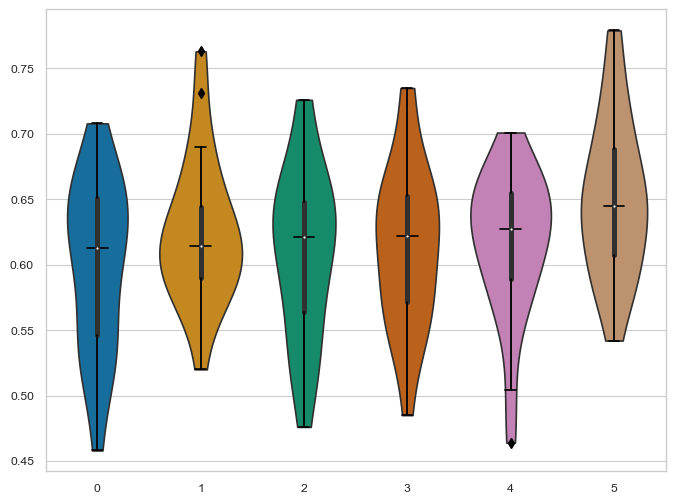

In [116]:
plt.clf()
sns.set_theme(context="paper", style="whitegrid",font_scale=1,palette='colorblind')
fig, ax = plt.subplots(1, figsize=(8, 6))

# Violin plot
sns.violinplot( data=val,ax=ax,cut=0,linewidth=1.2)
# plt.plot([-0.05,0.05], [np.median(val[0]),np.median(val[0])], color='black', linewidth=2)
#plt.axhline(np.median(val[0]), color='black', linestyle='--', linewidth=2)
# violin_parts = ax.collections
# for part in violin_parts:
#     if isinstance(part, plt.Polygon):
#         part.set_edgecolor('green')

# Boxplot
sns.boxplot( data=val, width=0.2, color="black")

# Adjust spacing between subplots
# plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()

#plt.figure(figsize=(7.5, 4))
# plt.figure(dpi=100)
# ,scale="width",width=0.5

# sorted_df = df[df['augment'].isin(mkda_relevant)].sort_values(by="augment", key=lambda column: column.map(lambda e: mkda_relevant.index(e)))
# ax= sns.violinplot(data=val,cut=0 , inner=None, zorder=0)
# sns.boxplot( data=val, zorder=4)
#plt.axhline(np.median(val[0]), color='black', linestyle='--')



# plt.xticks(ticks=np.linspace(0, len(app) - 1,
#             len(app), dtype=np.int32), labels=li)

# test_results
# plt.ylabel('Accuracy')
# plt.show()
# plt.savefig(f'{path}{name}.pgf', format='pgf', backend='pgf')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
ExAll v.s. ExImages: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.694e-02 stat=4.650e+01
Using zero_method  wilcox
ExAll v.s. propConst_LOF: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=1.135e+02
Using zero_method  wilcox
ExAll v.s. VGG_classes: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.699e-01 stat=7.650e+01
Using zero_method  wilcox
ExAll v.s. LDA_topics: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.572e-02 stat=5.050e+01


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Using zero_method  wilcox
ExAll v.s. MKGA: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.213e-03 stat=2.250e+01


(<AxesSubplot: xlabel='augment', ylabel='acc'>,
  <statannot.StatResult.StatResult at 0x256d1f6d250>])

<Figure size 640x480 with 0 Axes>

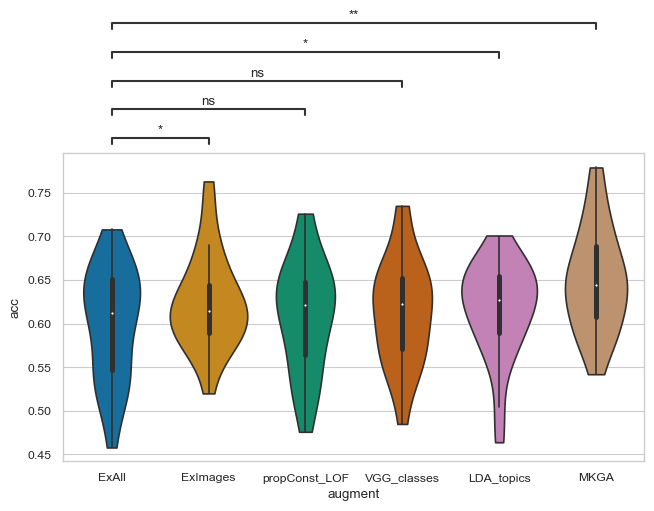

In [66]:
plt.clf()
sns.set_theme(context="paper", style="whitegrid",font_scale=1,palette='colorblind')
plt.figure(figsize=(7.5, 4))
# plt.figure(dpi=100)
# ,scale="width",width=0.5
sorted_df = df[df['augment'].isin(mkda_relevant)].sort_values(by="augment", key=lambda column: column.map(lambda e: mkda_relevant.index(e)))
ax= sns.violinplot(data=sorted_df,x='augment',y='acc',cut=0, )
#test_results = add_stat_annotation(ax, data=df, x='augment',y='acc', order=mkda_relevant,
                                   box_pairs=[("MKGA", "ExAll"),("LDA_topics", "ExAll"),("VGG_classes", "ExAll"),("propConst_LOF", "ExAll"), ("ExImages", "ExAll")],
                                   test='Wilcoxon', text_format='star',
                                   loc='outside', verbose=2)
# plt.xticks(ticks=np.linspace(0, len(app) - 1,
#             len(app), dtype=np.int32), labels=li)
ax
#test_results
# plt.ylabel('Accuracy')
# plt.show()
# plt.savefig(f'{path}{name}.pgf', format='pgf', backend='pgf')

In [60]:
df[df['augment'].isin(mkda_relevant)].sort_values(by="augment", key=lambda column: column.map(lambda e: mkda_relevant.index(e)))

,f1_micro,f1_macro,acc,count,dataset,eval_method,augment,embedder,a,b,c,d,base_pred_acc,statistic,pvalue,acc_delta,pct_acc_delta,p_test_passed
78,0.458,0.206,0.458,1.0,amplus,KNN,ExAll,DistMult,9154,0,0,10846,0.458,inf,0.000000e+00,0.000,0.000000,True
631,0.662,0.200,0.662,1.0,mdgenre,SVM,ExAll,RDF2Vec,1986,0,0,1014,0.662,inf,0.000000e+00,0.000,0.000000,True
629,0.622,0.163,0.622,1.0,mdgenre,SVM,ExAll,DistMult,1865,0,0,1135,0.622,inf,0.000000e+00,0.000,0.000000,True
628,0.605,0.140,0.605,1.0,mdgenre,KNN,ExAll,DistMult,1815,0,0,1185,0.605,inf,0.000000e+00,0.000,0.000000,True
454,0.619,0.187,0.619,1.0,dmgfull,KNN,ExAll,DistMult,12383,0,0,7617,0.619,inf,0.000000e+00,0.000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.643,0.230,0.643,1.0,dmgfull,SVM,MKGA,DistMult,12058,808,1107,6027,0.658,46.372846,9.776097e-12,-0.015,-2.279635,True
510,0.650,0.239,0.650,1.0,dmgfull,KNN,MKGA,RDF2Vec,11598,1405,987,6010,0.629,72.696070,1.512349e-17,0.021,3.338633,True
511,0.715,0.319,0.715,1.0,dmgfull,SVM,MKGA,RDF2Vec,12232,2071,985,4712,0.661,385.217605,9.099694e-86,0.054,8.169440,True
695,0.620,0.158,0.620,1.0,mdgenre,SVM,MKGA,DistMult,1740,121,125,1014,0.622,0.036585,8.483117e-01,-0.002,-0.321543,False
